In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import h5py
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

In [39]:
def collect_data(filename):
    
    # Open the file
    with h5py.File(filename, 'r') as f:
        # locs
        locs = f['locs']
        
        x_values = locs['x'][:]
        y_values = locs['y'][:]
        
    data = {
        'x': x_values,
        'y': y_values,
    }
    
    return pd.DataFrame(data)

def collect_group_data(hdf5_file, dataset_name):
    group_data_list = []

    with h5py.File(hdf5_file, 'r') as f:
        # Access the dataset
        dataset = f[dataset_name]

        # Extract the 'group', 'x', and 'y' fields
        group_data = dataset['group'][:]
        x_data = dataset['x'][:]
        y_data = dataset['y'][:]

        # Find unique groups
        unique_groups = np.unique(group_data)

        # Collect data for each group
        for group in unique_groups:
            indices = np.where(group_data == group)
            group_dict = {
                'group': int(group),
                'x': x_data[indices].tolist(),
                'y': y_data[indices].tolist()
            }
            group_data_list.append(group_dict)
    
    return group_data_list

def find_clusters_k_means(data, k):
    kmeans = KMeans(init="k-means++", n_clusters=k, n_init=4)
    kmeans.fit(data)
    return kmeans.labels_

def find_com(data, labels):
    com = []
    for i in range(max(labels)+1):
        x = np.mean(data['x'][labels == i])
        y = np.mean(data['y'][labels == i])
        com.append((x, y))
    return com
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.
    """
    pi2 = np.pi / 2

    # Get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # Calculate edge angles
    edges = hull_points[1:] - hull_points[:-1]
    angles = np.arctan2(edges[:, 1], edges[:, 0])
    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # Find rotation matrices
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles - pi2),
        np.cos(angles + pi2),
        np.cos(angles)
    ]).T
    rotations = rotations.reshape((-1, 2, 2))

    # Apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # Find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # Find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # Return the best box
    x1, x2 = max_x[best_idx], min_x[best_idx]
    y1, y2 = max_y[best_idx], min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

def distance_to_line(point, line_start, line_end):
    """Calculate the perpendicular distance from a point to a line."""
    if np.all(line_start == line_end):
        return np.linalg.norm(point - line_start)
    return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))

def find_closest_side(points, rectangle):
    distances = []
    for i in range(4):
        line_start = rectangle[i]
        line_end = rectangle[(i + 1) % 4]
        distances.append(np.mean([distance_to_line(point, line_start, line_end) for point in points]))
    closest_side = np.argmin(distances)
    return closest_side

def find_rotation_angle(rectangle, closest_side):
    # Find the angle of the closest side to make it parallel to the x-axis
    closest_line_start = rectangle[closest_side]
    closest_line_end = rectangle[(closest_side + 1) % 4]
    
    # Debugging: Print the coordinates of the closest line
    print(f"Closest line start: {closest_line_start}, end: {closest_line_end}")
    
    angle = np.arctan2(closest_line_end[1] - closest_line_start[1], closest_line_end[0] - closest_line_start[0])
    
    # Debugging: Print the initial calculated angle
    print(f"Initial calculated angle: {angle} radians ({np.degrees(angle)} degrees)")
    
    # Ensure the longer side is at the top (if not, adjust the angle by 90 degrees)
    if rectangle[1][0] < rectangle[1][1]:
        angle += np.pi / 2
        print(f"Adjusted angle by 90 degrees: {angle} radians ({np.degrees(angle)} degrees)")
    
    # Determine if the closest edge is the top or bottom edge
    if closest_line_start[1] < closest_line_end[1]:  # If the closest side is the bottom side
        angle += np.pi  # Rotate by 180 degrees to move it to the top
        print(f"Adjusted angle by 180 degrees (for bottom side): {angle} radians ({np.degrees(angle)} degrees)")
    
    final_angle = -angle  # Negate to rotate in the correct direction
    
    # Debugging: Print the final rotation angle
    print(f"Final rotation angle: {final_angle} radians ({np.degrees(final_angle)} degrees)")
    
    return final_angle

def adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side):
    """
    Adjust the final orientation of the image by comparing the y-values of the closest side 
    before and after rotating by an additional 180 degrees.
    """
    # Calculate the y-values of the closest edge
    closest_line_start = rotated_rect[closest_side]
    closest_line_end = rotated_rect[(closest_side + 1) % 4]
    avg_y_before = (closest_line_start[1] + closest_line_end[1]) / 2
    
    # Perform a 180-degree rotation
    rotated_data_180 = rotate_points(rotated_com, np.pi, find_center_of_rectangle(rotated_rect))
    rotated_rect_180 = rotate_points(rotated_rect, np.pi, find_center_of_rectangle(rotated_rect))
    
    # Calculate the y-values of the rotated edge after the 180-degree rotation
    closest_line_start_180 = rotated_rect_180[closest_side]
    closest_line_end_180 = rotated_rect_180[(closest_side + 1) % 4]
    avg_y_after = (closest_line_start_180[1] + closest_line_end_180[1]) / 2
    
    # Compare the average y-values and choose the orientation with the higher y-value
    if avg_y_after < avg_y_before:
        print("Adjusting by 180 degrees")
        return rotated_data_180, rotated_rect_180, rotation_angle + np.pi
    else:
        return rotated_com, rotated_rect, rotation_angle



def rotate_points(points, rotation_angle, pivot):
    """
    Rotate the given points around the pivot by the given rotation angle.
    """
    rotation_matrix = np.array([
        [np.cos(rotation_angle), -np.sin(rotation_angle)],
        [np.sin(rotation_angle), np.cos(rotation_angle)]
    ])
    rotated_points = np.dot(points - pivot, rotation_matrix.T) + pivot
    return rotated_points



def find_middle_left_most_com(rotated_com):
    # Sort each com in rotated_com based on its x value and take the first 3
    sorted_com = rotated_com[rotated_com[:, 0].argsort()][:3]
    second_highest_com = None
    
    # Find the second highest y value in sorted_com
    for com in sorted_com:
        if com[1] != max(sorted_com[:, 1]) and com[1] != min(sorted_com[:, 1]):
            second_highest_com = com
            break
    return second_highest_com

def find_right_most_coms(rotated_com):
    # Sort each com in rotated_com based on its x value
    sorted_com = rotated_com[rotated_com[:, 0].argsort()]
    right_most_com = sorted_com[-1]
    second_right_most_com = sorted_com[-2]
    return right_most_com, second_right_most_com

def find_center_of_rectangle(rectangle):
    return np.mean(rectangle, axis=0)


def find_robot(rotated_com):
    
    #finding the center of the rectangle
    center_x, center_y = find_center_of_rectangle(rotated_com)
    
    distances = np.sqrt((rotated_com[:, 0] - center_x) ** 2 + (rotated_com[:, 1] - center_y) ** 2)
    closest_com_index = np.argmin(distances)
    closest_com = rotated_com[closest_com_index]
    
    return closest_com
#drawing line between two points without using cv2
def draw_line_between_points(p1, p2, color='white'):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color)
    
def intersection_between_point_line(point, line):
    x0, y0 = point
    x1, y1 = line[0]
    x2, y2 = line[1]
    if x1 == x2:
        return x1, y0
    m = (y2 - y1) / (x2 - x1)
    c = y1 - m * x1
    x = (m * y0 + x0 - m * c) / (m ** 2 + 1)
    y = m * x + c
    return x, y
    

def draw_line_between_point_and_line( p1, p2, p3):
    
    #finding the intersection point
    right_line = np.array([p1, p2])
    intersection_x, intersection_y = intersection_between_point_line(p3, right_line)
    intersection_point = np.array([intersection_x, intersection_y])
    
    #plotting the points between the points p3 and intersection point
    plt.plot([p3[0], intersection_point[0]], [p3[1], intersection_point[1]], color='magenta')

def calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com):
    def distance_point_to_line(point, line):
        x0, y0 = point
        x1, y1 = line[0]
        x2, y2 = line[1]
        return np.abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1) / np.sqrt((y2-y1)**2 + (x2-x1)**2)

    right_line = np.array([right_most_com, second_right_most_com])
    intersection_point = intersection_between_point_line(robot_com, right_line)
    normalizing_point = intersection_between_point_line(second_highest_com, right_line)
    robot_distance = distance_point_to_line(robot_com, right_line)
    normalizing_distance = distance_point_to_line(second_highest_com, right_line)
    ratio = robot_distance / normalizing_distance

    plt.axes().set_facecolor('black')
    ax = plt.gca()
    ax.invert_yaxis()  # Invert y-axis to correct orientation
    plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', s=10)
    plt.scatter(second_highest_com[0], second_highest_com[1], color='magenta', s=10)
    plt.scatter(right_most_com[0], right_most_com[1], color='magenta', s=10)
    plt.scatter(second_right_most_com[0], second_right_most_com[1], color='magenta', s=10)
    plt.scatter(robot_com[0], robot_com[1], color='magenta', s=10)

    draw_line_between_points(right_most_com, second_right_most_com, color='magenta')
    draw_line_between_point_and_line(right_most_com, second_right_most_com, robot_com)
    draw_line_between_point_and_line(second_right_most_com, right_most_com, second_highest_com)

    plt.show()

    return ratio


In [58]:
def plot_helper(data=None, labels=None, com=None, rotated_data=None, rotated_com=None, rotated_rect=None, second_highest_com=None, right_most_com=None, second_right_most_com=None, robot_com=None, title="Plot"):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_facecolor('black')
    ax.invert_yaxis()  # Invert y-axis to correct orientation
    
    if data is not None and labels is not None:
        plt.scatter(data['x'], data['y'], c=labels, cmap='viridis', s=10, alpha=0.5)
    elif data is not None:
        plt.scatter(data['x'], data['y'], s=10, alpha=0.5)
    
    if com is not None and len(com) > 0:
        com = np.array(com)
        plt.scatter(com[:, 0], com[:, 1], c='red', s=100, label='COMs')
    
    if rotated_data is not None and rotated_data.size > 0:
        plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    
    if rotated_com is not None and rotated_com.size > 0:
        plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', s=100, label='Rotated COMs')
   
    if rotated_rect is not None and rotated_rect.size > 0:
        for i in range(4):
            plt.plot([rotated_rect[i, 0], rotated_rect[(i + 1) % 4, 0]], 
                     [rotated_rect[i, 1], rotated_rect[(i + 1) % 4, 1]], 'b-')

    if second_highest_com is not None and len(second_highest_com) > 0:
        plt.scatter(second_highest_com[0], second_highest_com[1], color='magenta', s=100, label='Second Highest COM')
    

    if right_most_com is not None and len(right_most_com) > 0:
        plt.scatter(right_most_com[0], right_most_com[1], color='magenta', s=100, label='Right Most COM')
   
    if second_right_most_com is not None and len(second_right_most_com) > 0:
        plt.scatter(second_right_most_com[0], second_right_most_com[1], color='magenta', s=100, label='Second Right Most COM')
    
    if robot_com is not None and len(robot_com) > 0:
        plt.scatter(robot_com[0], robot_com[1], color='magenta', s=100, label='Robot COM')
    
    
    plt.title(title)
    plt.legend()
    plt.show()




def process_origami_ratio(filename, k):
    print("Starting process_origami_ratio")
    
    data = collect_data(filename)
    print("Data collected:\n", data.head())
    plot_helper(data=data, title="Initial Data")
    
    labels = find_clusters_k_means(data, k)
    print("K-Means labels:\n", labels)
    plot_helper(data=data, labels=labels, title="K-Means Clustering")

    com = find_com(data, labels)
    print("Centers of Mass (COM):\n", com)
    plot_helper(data=data, labels=labels, com=com, title="Centers of Mass")

    min_bounding_rect = minimum_bounding_rectangle(np.array(com))
    print("Minimum Bounding Rectangle:\n", min_bounding_rect)
    
    closest_side = find_closest_side(np.array(com), min_bounding_rect)
    print("Closest side of bounding rectangle:\n", closest_side)
    
    rotation_angle = find_rotation_angle(min_bounding_rect, closest_side)
    print("Rotation angle:\n", rotation_angle)
    
    rotated_data = rotate_points(data.values, rotation_angle, min_bounding_rect[closest_side])
    print("Rotated Data:\n", rotated_data[:5])
    
    rotated_com = rotate_points(np.array(com), rotation_angle, min_bounding_rect[closest_side])
    print("Rotated Centers of Mass (COM):\n", rotated_com)
    
    rotated_rect = rotate_points(min_bounding_rect, rotation_angle, min_bounding_rect[closest_side])
    
    # Adjust the final orientation if needed
    rotated_com, rotated_rect, final_angle = adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side)
        
    if (rotation_angle != final_angle):
        #totae the data points by 180 degrees
        rotated_data = rotate_points(rotated_data, np.pi, find_center_of_rectangle(rotated_rect))
        
    print(f"Final rotation angle after adjustment: {final_angle} radians ({np.degrees(final_angle)} degrees)")
    
    plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title="Final Adjusted Data and COMs")

    second_highest_com = find_middle_left_most_com(rotated_com)
    print("Second Highest COM:\n", second_highest_com)
    
    right_most_com, second_right_most_com = find_right_most_coms(rotated_com)
    print("Right Most COM:\n", right_most_com)
    print("Second Right Most COM:\n", second_right_most_com)
    
    robot_com = find_robot(rotated_com)
    print("Robot COM:\n", robot_com)

    ratio = calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com)
    print("Ratio:\n", ratio)
    
    

    return ratio


Starting process_origami_ratio
Data collected:
             x          y
0  111.875267  60.029800
1  111.827614  60.045071
2  111.803627  60.154224
3  111.851440  60.342262
4  111.837921  60.320156


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


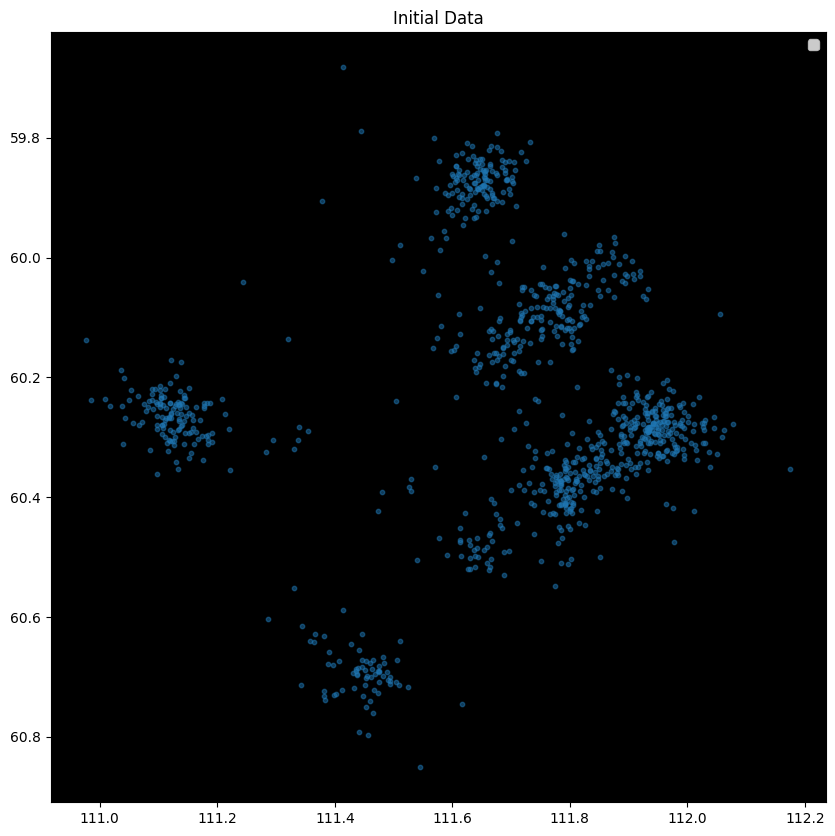

K-Means labels:
 [6 6 6 1 1 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 6 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 6 6 6 5 2 2 2 2 6
 6 6 6 6 6 6 6 6 6 6 0 0 0 4 4 4 4 4 1 1 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 5 1
 1 3 3 3 3 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 3 3 3 7 1 3 3 3 3 3 3 3 3 3 3 3 5 1 1 3 3 7 2 3 3 0 0 0 0 2 2 1
 1 1 1 2 0 0 1 1 1 1 1 1 3 3 1 1 2 2 2 2 2 2 0 5 5 1 1 3 3 3 3 3 3 3 1 3 1
 3 1 1 1 1 1 1 1 6 5 5 5 5 5 5 5 5 5 5 6 6 6 6 1 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 1 1 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 0 0 0 0 7 7 1 7 7 7 7 6
 6 0 0 0 2 2 2 2 2 2 2 6 6 5 5 5 3 3 3 7 7 7 7 7 7 7 7 7 2 2 2 2 2 5 2 2 2
 2 0 0 1 1 7 7 7 7 7 7 7 7 7 7 7 7 4 4 0 0 0 0 0 0 0 5 5 5 5 5 5 7 0 3 3 3
 1 1 1 5 5 5 5 0 0 0 0 0 0 0 0 0 0 2 0 6 6 6 6 6 6 4 4 4 4 2 3 3 3 3 3 4 4
 0 5 6 6 6 7 1 1 5 2 2 1 1 1 1 3 3 2 2 6 0 0 0 0 0 4 4 4 4 4 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 6 3 3 3 3 5 5
 5 5 5 7

/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


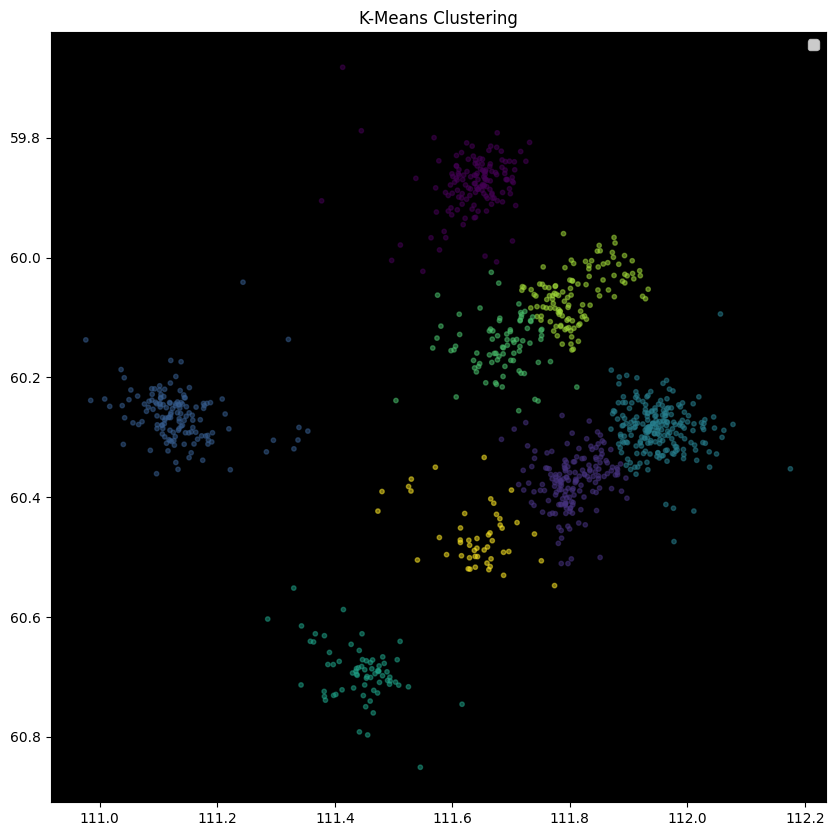

Centers of Mass (COM):
 [(np.float32(111.6368), np.float32(59.877396)), (np.float32(111.805565), np.float32(60.373165)), (np.float32(111.1327), np.float32(60.26338)), (np.float32(111.95023), np.float32(60.285942)), (np.float32(111.443954), np.float32(60.693012)), (np.float32(111.68343), np.float32(60.147842)), (np.float32(111.811005), np.float32(60.06247)), (np.float32(111.6388), np.float32(60.46383))]


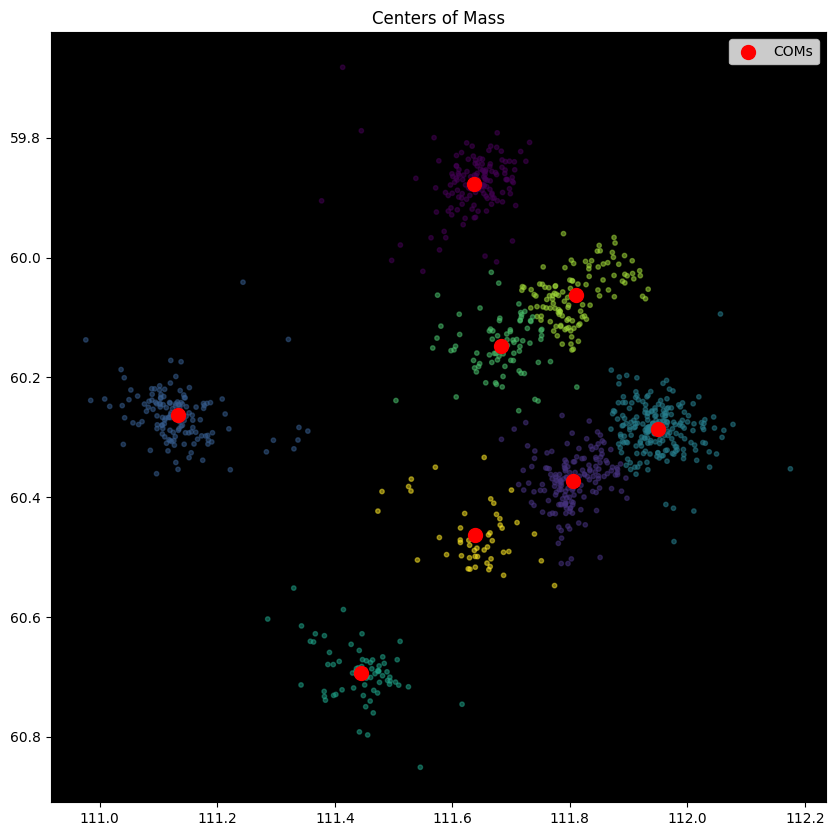

Minimum Bounding Rectangle:
 [[111.97969055  60.2828064 ]
 [111.65727234  59.86171722]
 [111.121521    60.27193069]
 [111.44393921  60.69301987]]
Closest side of bounding rectangle:
 3
Closest line start: [111.44393921  60.69301987], end: [111.97969055  60.2828064 ]
Initial calculated angle: -0.653460287914256 radians (-37.44051657689051 degrees)
Final rotation angle: 0.653460287914256 radians (37.44051657689051 degrees)
Rotation angle:
 0.653460287914256
Rotated Data:
 [[112.18960294  60.42865396]
 [112.14248367  60.41180813]
 [112.05707985  60.48389208]
 [111.98072771  60.66225888]
 [111.98343277  60.63648803]]
Rotated Centers of Mass (COM):
 [[112.09291841  60.16267545]
 [111.92551621  60.65890582]
 [111.45801373  60.16267567]
 [112.09340704  60.67760148]
 [111.44395596  60.69302309]
 [111.96552789  60.40575476]
 [112.11871882  60.4155252 ]
 [111.73799068  60.62950994]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 3.795052941504049 radians (217.4405165768905 degre

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


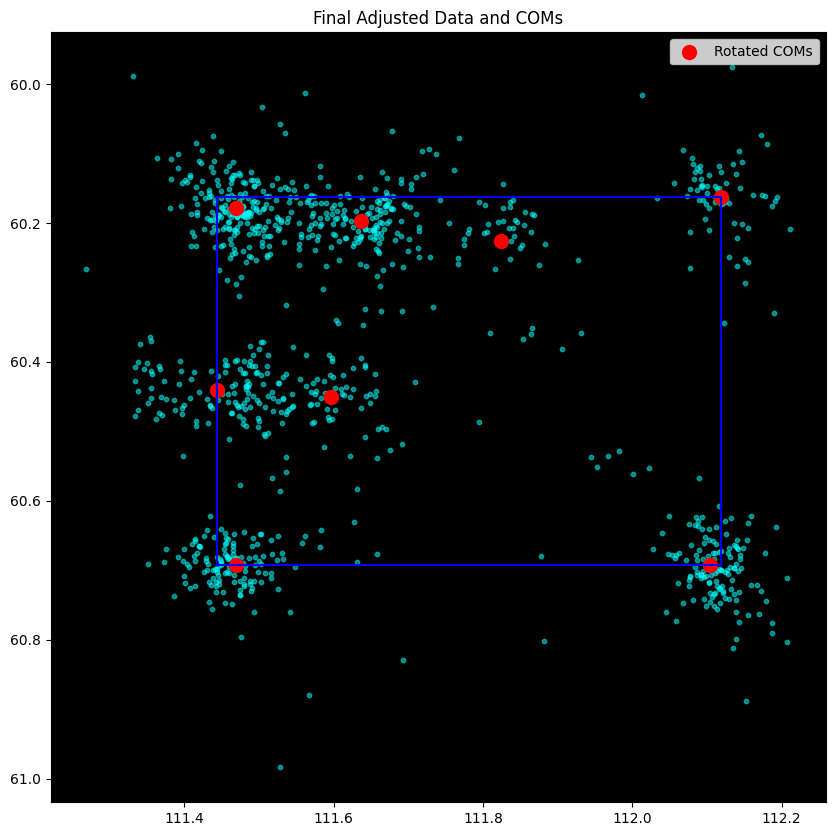

Second Highest COM:
 [111.4439229   60.44016598]
Right Most COM:
 [112.11868576  60.16266809]
Second Right Most COM:
 [112.10462799  60.69301551]
Robot COM:
 [111.59711383  60.44993642]


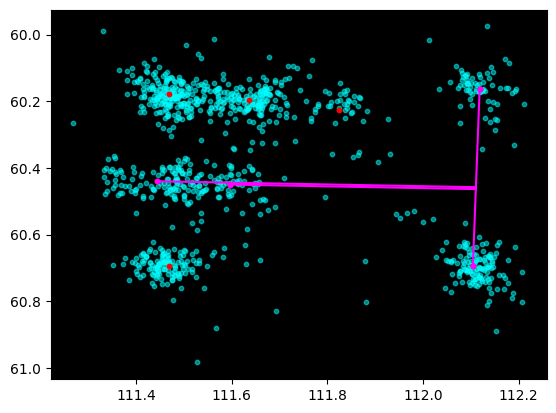

Ratio:
 0.7700805574788557


In [59]:
ratio = process_origami_ratio('data/test_1.hdf5', 8)

In [63]:
import matplotlib.pyplot as plt

def generate_ratio_histogram(ratios, bins=10, title="Histogram of Ratios", xlabel="Ratio", ylabel="Frequency"):
    """
    Generates a histogram of the provided ratios.
    
    :param ratios: List of ratio values to plot.
    :param bins: Number of bins for the histogram.
    :param title: Title of the histogram plot.
    :param xlabel: Label for the x-axis.
    :param ylabel: Label for the y-axis.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(ratios, bins=bins, color='blue', alpha=0.7, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def process_multiple_origami_ratio(filename, k):
    print("Starting process_multiple_origami_ratio")
    
    # Collect data for each group
    group_data_list = collect_group_data(filename, 'locs')
    
    ratios = []  # List to store the ratios for each group
    
    # Process each group
    for group_data in group_data_list:
        group_id = group_data['group']
        data = pd.DataFrame({
            'x': group_data['x'],
            'y': group_data['y']
        })
        print(f"\nProcessing Group {group_id}")
        print("Data collected:\n", data.head())
        plot_helper(data=data, title=f"Initial Data - Group {group_id}")
        
        labels = find_clusters_k_means(data, k)
        print("K-Means labels:\n", labels)
        plot_helper(data=data, labels=labels, title=f"K-Means Clustering - Group {group_id}")
    
        com = find_com(data, labels)
        print("Centers of Mass (COM):\n", com)
        plot_helper(data=data, labels=labels, com=com, title=f"Centers of Mass - Group {group_id}")
    
        min_bounding_rect = minimum_bounding_rectangle(np.array(com))
        print("Minimum Bounding Rectangle:\n", min_bounding_rect)
        
        closest_side = find_closest_side(np.array(com), min_bounding_rect)
        print("Closest side of bounding rectangle:\n", closest_side)
        
        rotation_angle = find_rotation_angle(min_bounding_rect, closest_side)
        print("Rotation angle:\n", rotation_angle)
        
        rotated_data = rotate_points(data.values, rotation_angle, min_bounding_rect[closest_side])
        print("Rotated Data:\n", rotated_data[:5])
        
        rotated_com = rotate_points(np.array(com), rotation_angle, min_bounding_rect[closest_side])
        print("Rotated Centers of Mass (COM):\n", rotated_com)
        
        rotated_rect = rotate_points(min_bounding_rect, rotation_angle, min_bounding_rect[closest_side])
        
        # Adjust the final orientation if needed
        rotated_com, rotated_rect, final_angle = adjust_final_orientation(rotated_com, rotated_rect, rotation_angle, closest_side)
        
        if (rotation_angle != final_angle):
            # Rotate the data points by 180 degrees
            rotated_data = rotate_points(rotated_data, np.pi, find_center_of_rectangle(rotated_rect))
        
        print(f"Final rotation angle after adjustment: {final_angle} radians ({np.degrees(final_angle)} degrees)")
        
        plot_helper(rotated_data=rotated_data, rotated_com=rotated_com, rotated_rect=rotated_rect, title=f"Final Adjusted Data and COMs - Group {group_id}")

        second_highest_com = find_middle_left_most_com(rotated_com)
        print("Second Highest COM:\n", second_highest_com)
        
        right_most_com, second_right_most_com = find_right_most_coms(rotated_com)
        print("Right Most COM:\n", right_most_com)
        print("Second Right Most COM:\n", second_right_most_com)
        
        robot_com = find_robot(rotated_com)
        print("Robot COM:\n", robot_com)
    
        ratio = calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot_com, right_most_com, second_right_most_com)
        print("Ratio:\n", ratio)
        
        ratios.append(ratio)  # Store the ratio for this group
    
    generate_ratio_histogram(ratios)  # Generate the histogram of all the collected ratios
    
    return ratios


Starting process_multiple_origami_ratio

Processing Group 0
Data collected:
            x         y
0  42.897629  5.893465
1  42.816818  5.834262
2  42.830162  5.812670
3  42.875660  5.817399
4  42.836132  5.822851


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


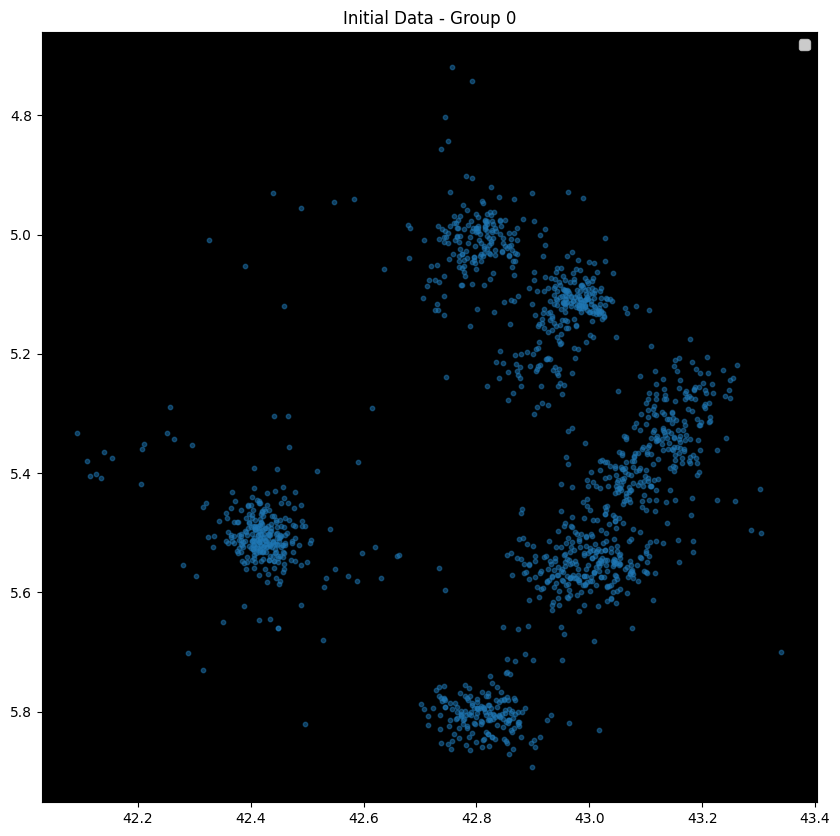

K-Means labels:
 [1 1 1 ... 2 1 0]


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


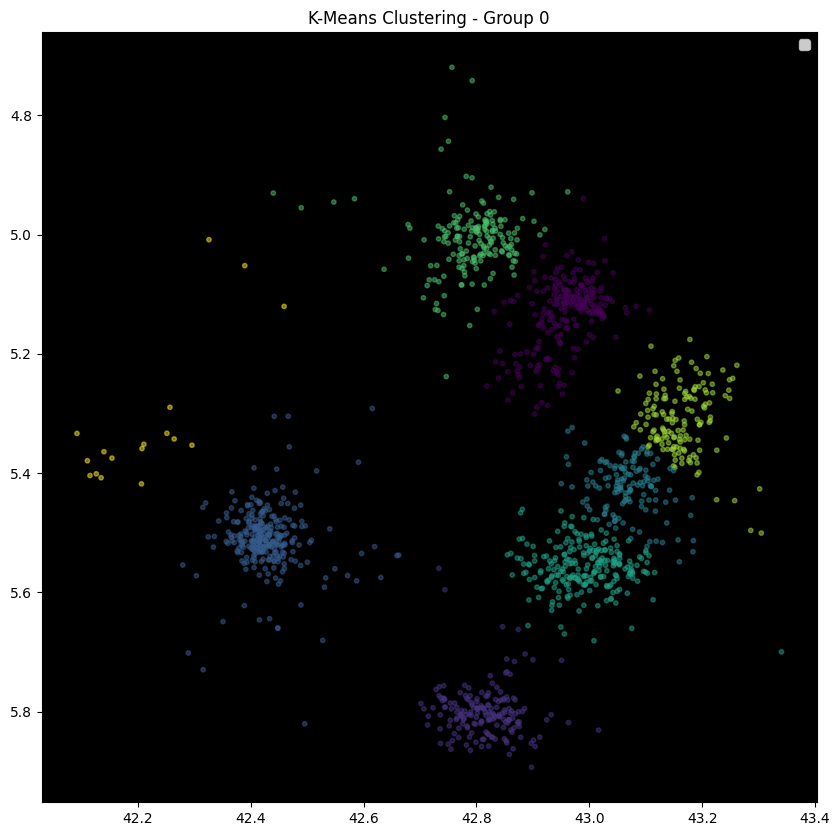

Centers of Mass (COM):
 [(np.float64(42.959169372310484), np.float64(5.132997377132012)), (np.float64(42.8155654092853), np.float64(5.799916152204021)), (np.float64(42.428676454824355), np.float64(5.510897815868419)), (np.float64(43.06775432010349), np.float64(5.422988068285606)), (np.float64(42.9918169753964), np.float64(5.55823554067169)), (np.float64(42.7921301559363), np.float64(5.007392254621623)), (np.float64(43.16339725776007), np.float64(5.310687596365909)), (np.float64(42.21997384464039), np.float64(5.311504700604607))]


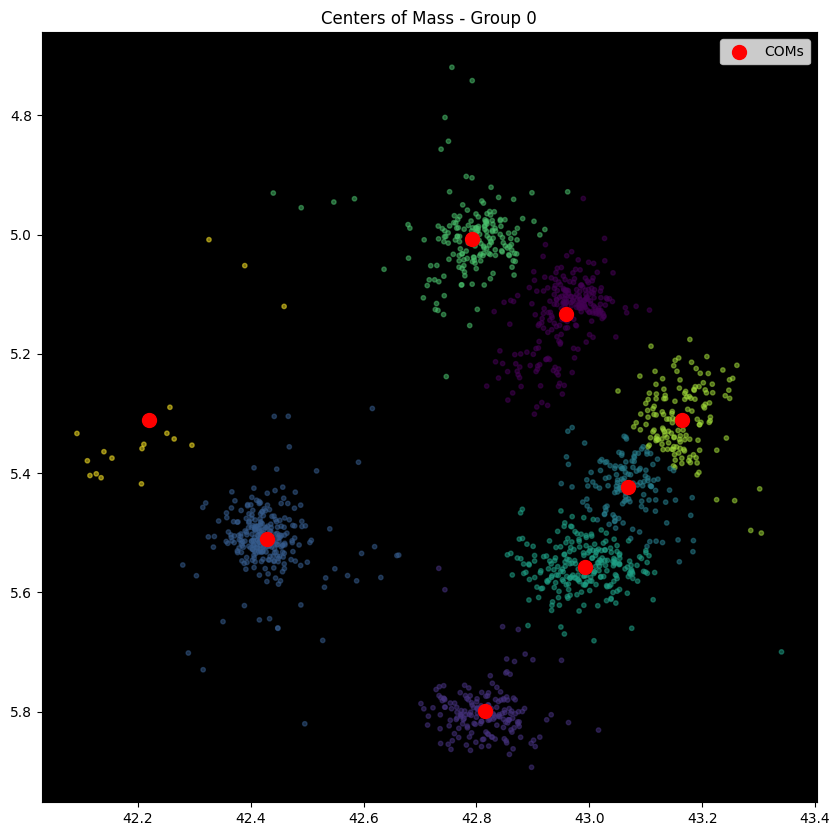

Minimum Bounding Rectangle:
 [[43.18715806  5.30249065]
 [42.5707167   4.84198937]
 [42.19912405  5.33941488]
 [42.81556541  5.79991615]]
Closest side of bounding rectangle:
 3
Closest line start: [42.81556541  5.79991615], end: [43.18715806  5.30249065]
Initial calculated angle: -0.9291976001362098 radians (-53.23910082148951 degrees)
Final rotation angle: 0.9291976001362098 radians (53.23910082148951 degrees)
Rotation angle:
 0.9291976001362098
Rotated Data:
 [[42.7897327   5.92164726]
 [42.78879907  5.82147527]
 [42.81408336  5.81924313]
 [42.83752438  5.85852338]
 [42.80950028  5.83011871]]
Rotated Centers of Mass (COM):
 [[43.43580437  5.51582747]
 [42.81556541  5.79991615]
 [42.81556541  5.31699311]
 [43.26846683  5.77637198]
 [43.11466792  5.79647804]
 [43.43646253  5.3068339 ]
 [43.41567533  5.78578611]
 [42.85040349  5.03046091]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 4.070790253726003 radians (233.2391008214895 degrees)


/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


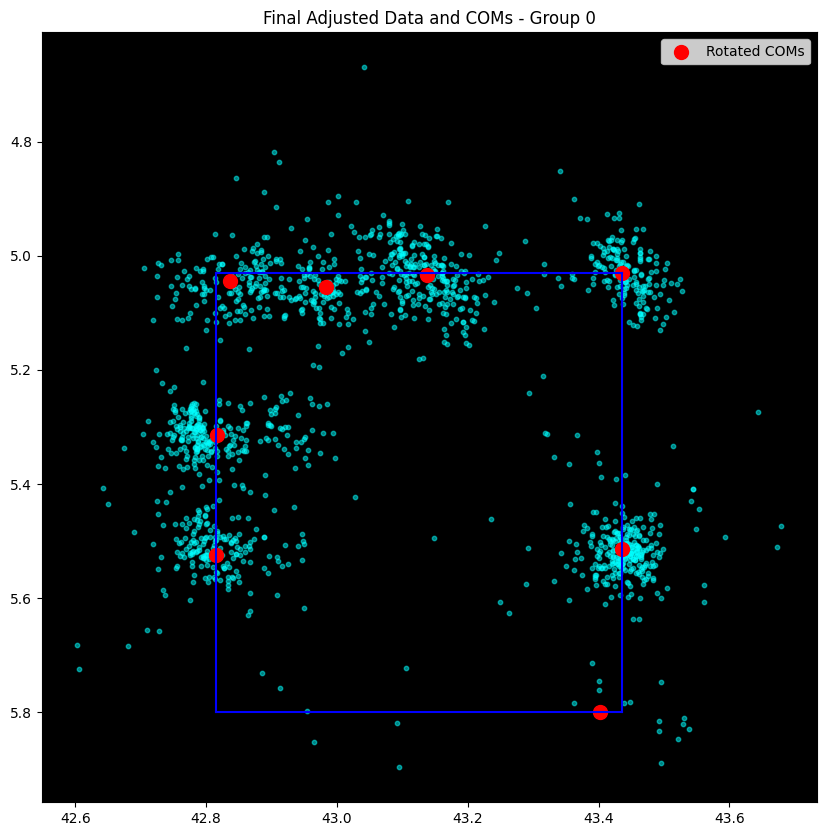

Second Highest COM:
 [42.81622356  5.31454959]
Right Most COM:
 [43.43646253  5.03046091]
Second Right Most COM:
 [43.43646253  5.51338395]
Robot COM:
 [43.13736002  5.03389903]


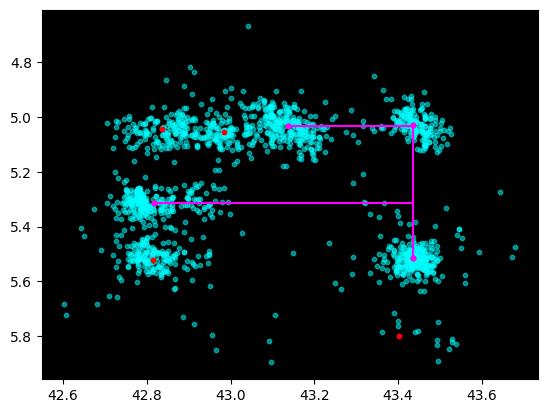

Ratio:
 0.4822375367441374

Processing Group 1
Data collected:
            x         y
0  74.181908  2.675268
1  74.218697  2.590031
2  74.369797  3.188938
3  74.364662  3.175110
4  74.386177  3.169834


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


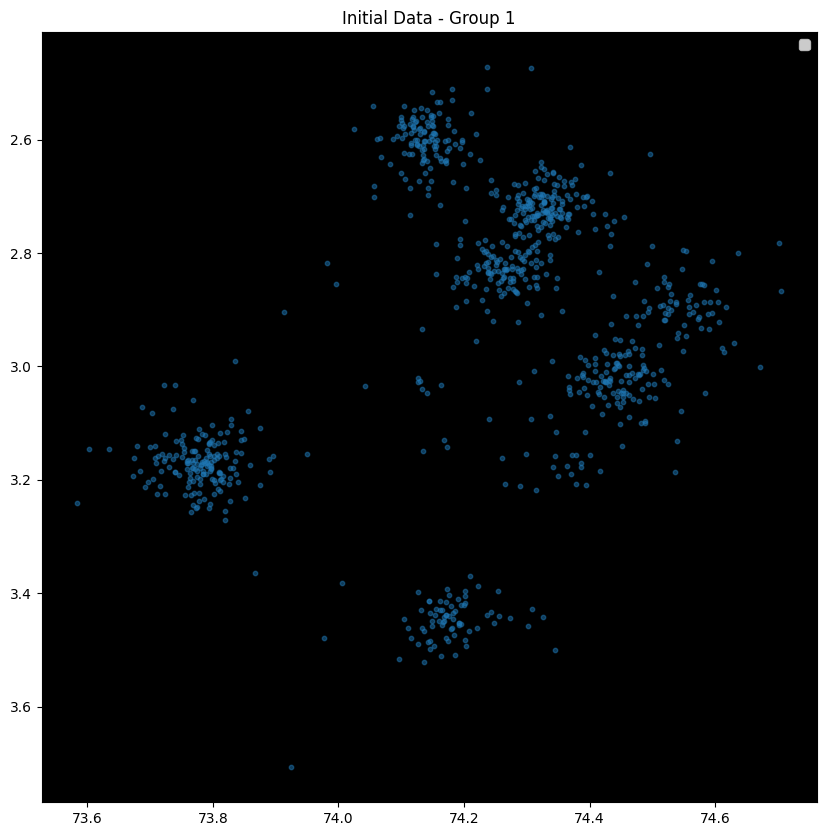

K-Means labels:
 [4 4 2 2 2 2 2 2 2 2 2 7 2 1 1 0 3 3 7 7 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 7 7 7 1 1 1 6 6 6 7 7 7 7 7 7 7 6 6 1 1 1 1 1 1 1 4 4 5 5 4 4 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 3 3 3 3 7 7 3 3 7 7 5 5 5 5 5 5 5 5 0 0 0 3 0 6 6 6 6 7 7 7 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 2 2 2 2 6 6 6 6 6 6 6 6 7 7 7 7 6
 6 6 6 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 5 5 5 5 5 5
 5 5 4 4 4 4 4 4 4 7 7 7 7 7 7 7 4 4 4 4 5 5 5 3 5 0 7 6 6 6 6 6 6 6 6 4 4
 0 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 5 5 6 5 5 6 4 4 0 0 0 0 0 0 5 0 0 0 0 0 0
 0 0 0 0 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0 0 2 2 2 2 1 0 4 4 4 7 7 7
 7 2 7 7 7 7 4 5 0 0 1 1 1 1 1 1 1 1 7 7 7 7 7 7 7 7 7 7 7 7 7 4 4 2 5 4 4
 4 4 4 1 1 1 1 1 1 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 0 5 5 0 4 0 3 1 1
 1 1 1 1 1 4 4 4 4 1 1 1 1 1 1 1 4 4 4 4 4 4 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 7 7 2 2 2 5 0 0 4 4 4 4 4 2 1 1 1 1 1 5 5 0 0 0 0 0 0 0 0 0 0
 4 4 5 5

/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


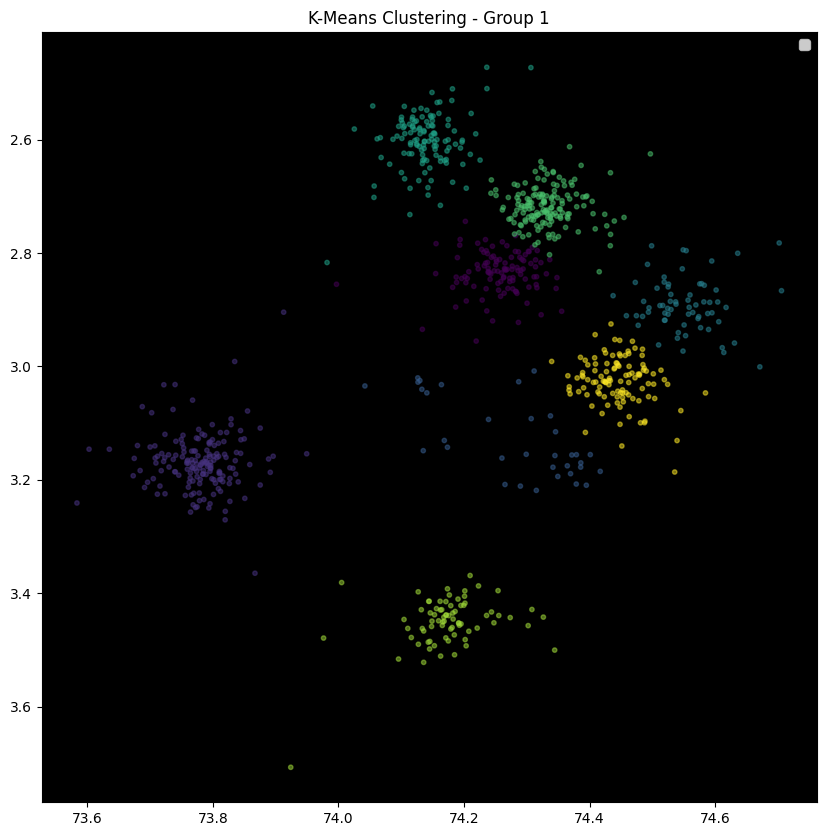

Centers of Mass (COM):
 [(np.float64(74.25677937000721), np.float64(2.834714855159725)), (np.float64(73.77946074708493), np.float64(3.168646534046013)), (np.float64(74.27897172815659), np.float64(3.127372938043931)), (np.float64(74.55210321599787), np.float64(2.89046692125725)), (np.float64(74.13930593443311), np.float64(2.602285968370674)), (np.float64(74.33265622046686), np.float64(2.7179434299468994)), (np.float64(74.17461903889973), np.float64(3.4499339803059894)), (np.float64(74.44544079981813), np.float64(3.026104297112981))]


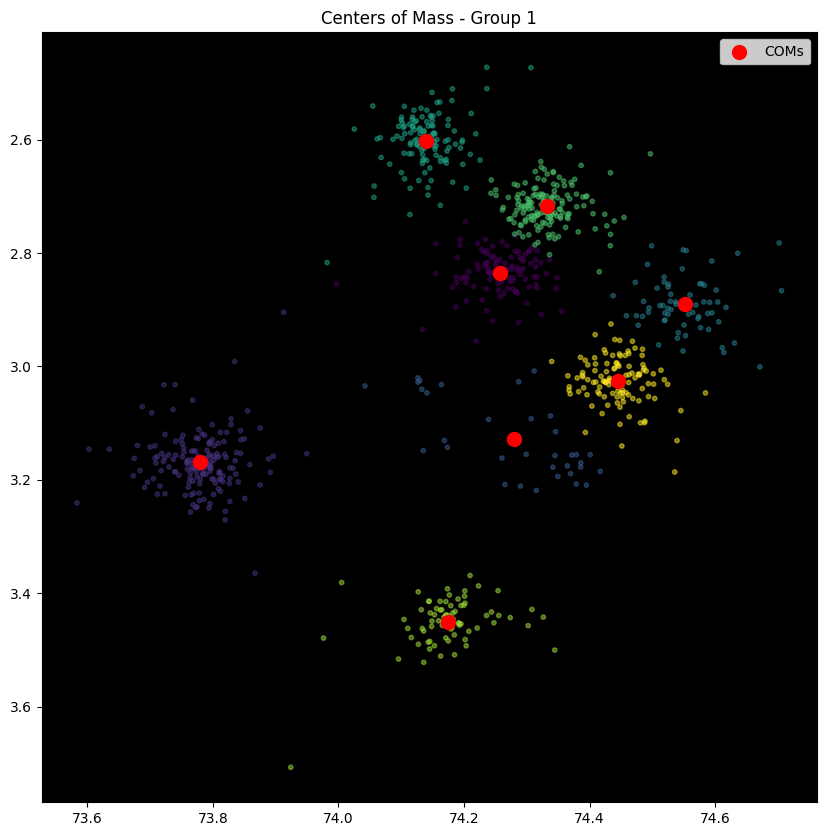

Minimum Bounding Rectangle:
 [[74.56344308  2.87366017]
 [74.14616792  2.59211586]
 [73.75734388  3.16838966]
 [74.17461904  3.44993398]]
Closest side of bounding rectangle:
 3
Closest line start: [74.17461904  3.44993398], end: [74.56344308  2.87366017]
Initial calculated angle: -0.977238350767572 radians (-55.991633077307014 degrees)
Final rotation angle: 0.977238350767572 radians (55.991633077307014 degrees)
Rotation angle:
 0.977238350767572
Rotated Data:
 [[74.82085966  3.02269439]
 [74.91209416  3.0055164 ]
 [74.5001389   3.46574895]
 [74.50872969  3.45375852]
 [74.52513721  3.46864223]]
Rotated Centers of Mass (COM):
 [[74.73056199  3.17394063]
 [74.18677638  2.96503718]
 [74.50037384  3.35602486]
 [74.84952473  3.44993398]
 [74.85753075  2.94655961]
 [74.86979933  3.1715273 ]
 [74.17461904  3.44993398]
 [74.67742955  3.43737942]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 4.118831004357365 radians (235.99163307730703 degrees)


/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


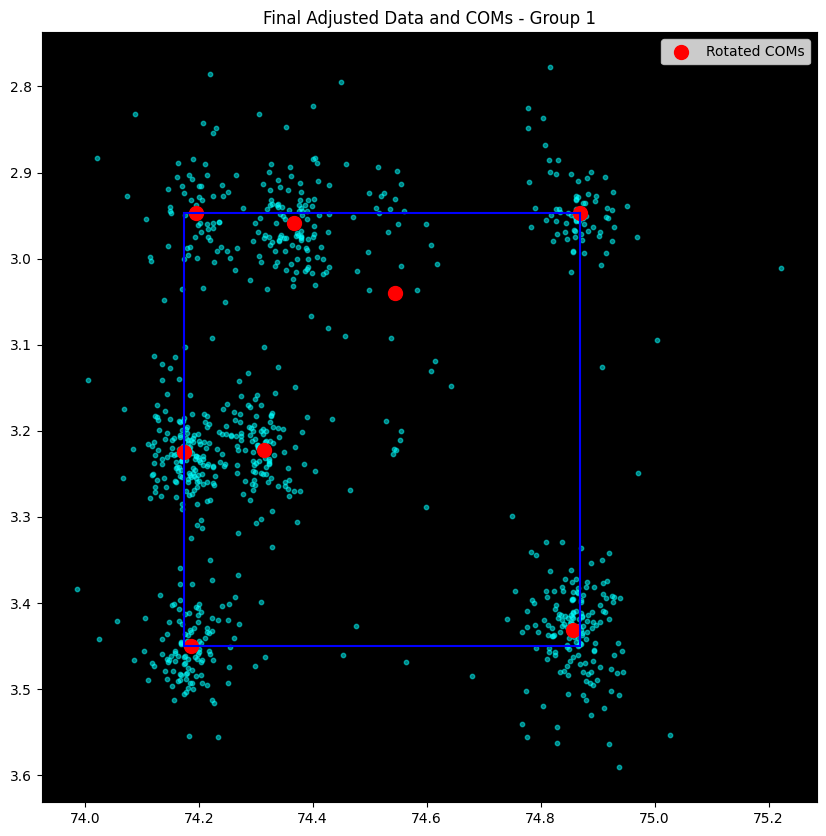

Second Highest COM:
 [74.17461904  3.22496629]
Right Most COM:
 [74.86979933  2.94655961]
Second Right Most COM:
 [74.85764199  3.4314564 ]
Robot COM:
 [74.31385638  3.22255296]


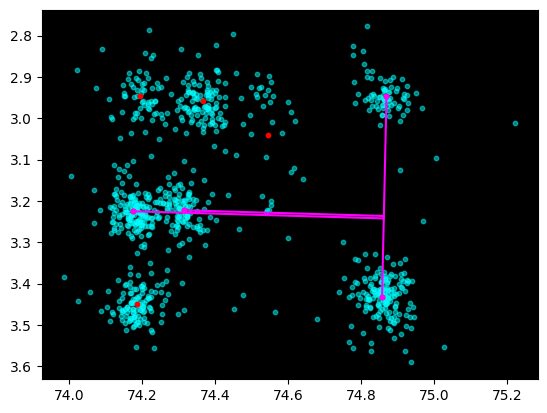

Ratio:
 0.7977668958675053

Processing Group 2
Data collected:
            x          y
0  80.229553  11.981121
1  80.168312  11.962978
2  80.124626  11.972430
3  80.120476  11.994550
4  80.130730  11.978308


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


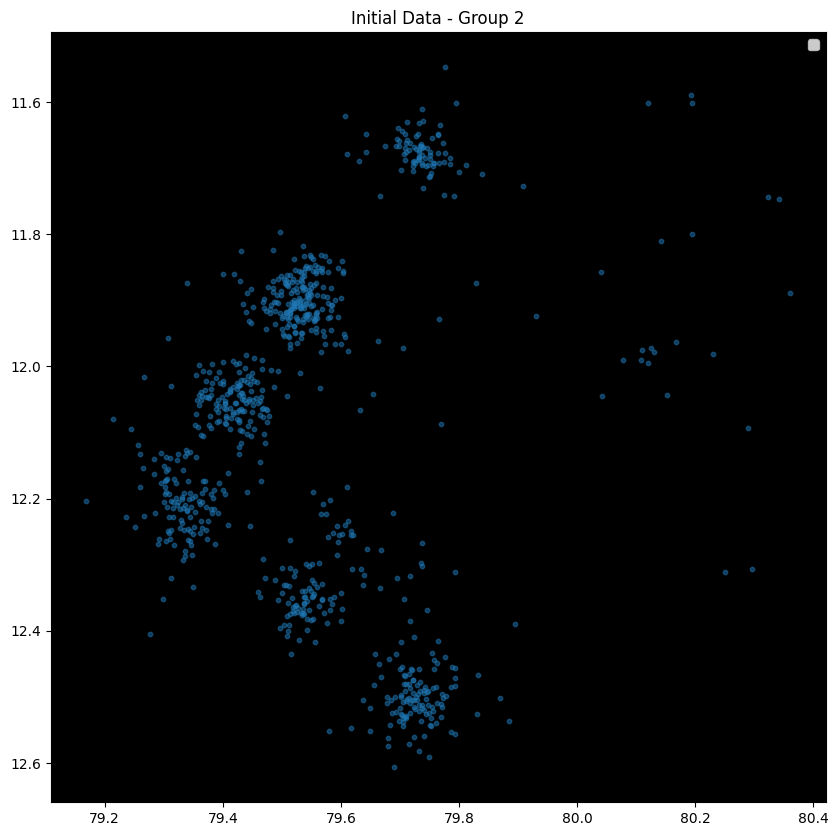

K-Means labels:
 [4 4 4 4 4 0 0 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 7 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 6 3 4 6 0 0 0 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 0 0 0 7 5 5 5 5 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 2 2 2 6 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 4 4 3 1 1
 1 1 1 0 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 6 2 2 2 2 2 2 2 5 5 5 7 0 3 3 3 3 3 2 5 5 1 1 1 1 1 1 1 1 7 7 2 2 5
 3 3 3 3 3 3 5 6 6 1 1 5 5 5 5 2 2 2 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 0 2 2 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 1 1 7 6
 1 6 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 3 3 3 3 3 3 3 4 4 1 3 3 3 6 5
 5 5 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5 4 7 0 0 0 0 0 0 0 0 0 0 0 6 6 6 2 2 0 2
 2 2 6 6 6 6 6 6 6 6 6 1 1 5 5 6 6 6 6 5 4 4 7 5 5 6 6 6 6 2 2 2 2 6 2 2 1
 1 1 1 1

/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


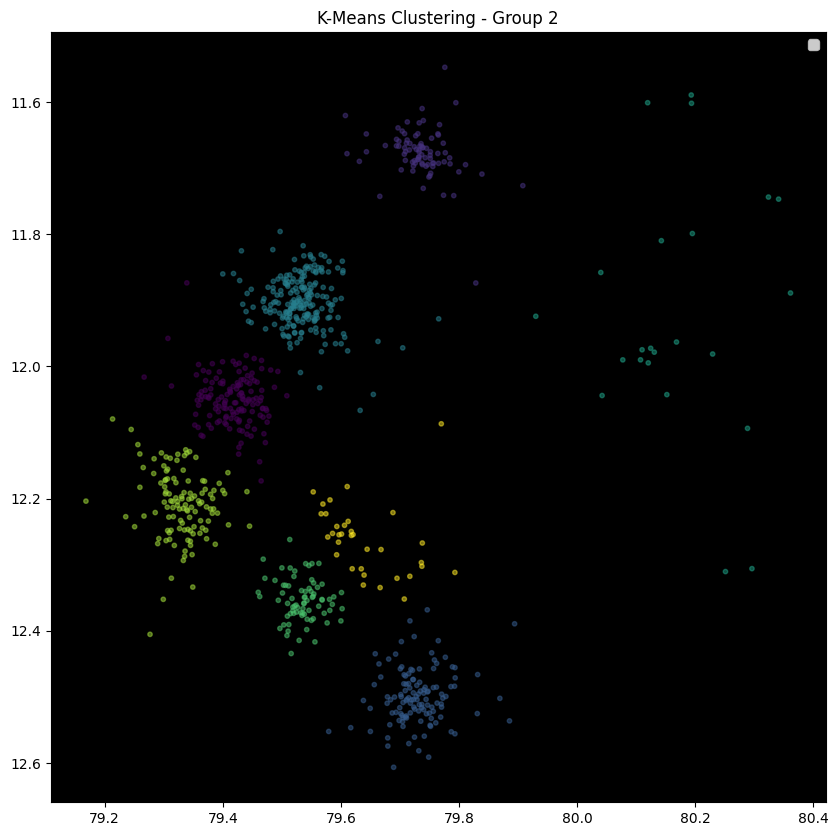

Centers of Mass (COM):
 [(np.float64(79.41719585445756), np.float64(12.050053156859486)), (np.float64(79.73547944568452), np.float64(11.677294004531134)), (np.float64(79.72918319702148), np.float64(12.499668637260061)), (np.float64(79.53313579830512), np.float64(11.902821242526809)), (np.float64(80.17131506878397), np.float64(11.921803806139076)), (np.float64(79.53449349654348), np.float64(12.354004257603696)), (np.float64(79.33030194194377), np.float64(12.20881382757876)), (np.float64(79.64012572344612), np.float64(12.261649047627168))]


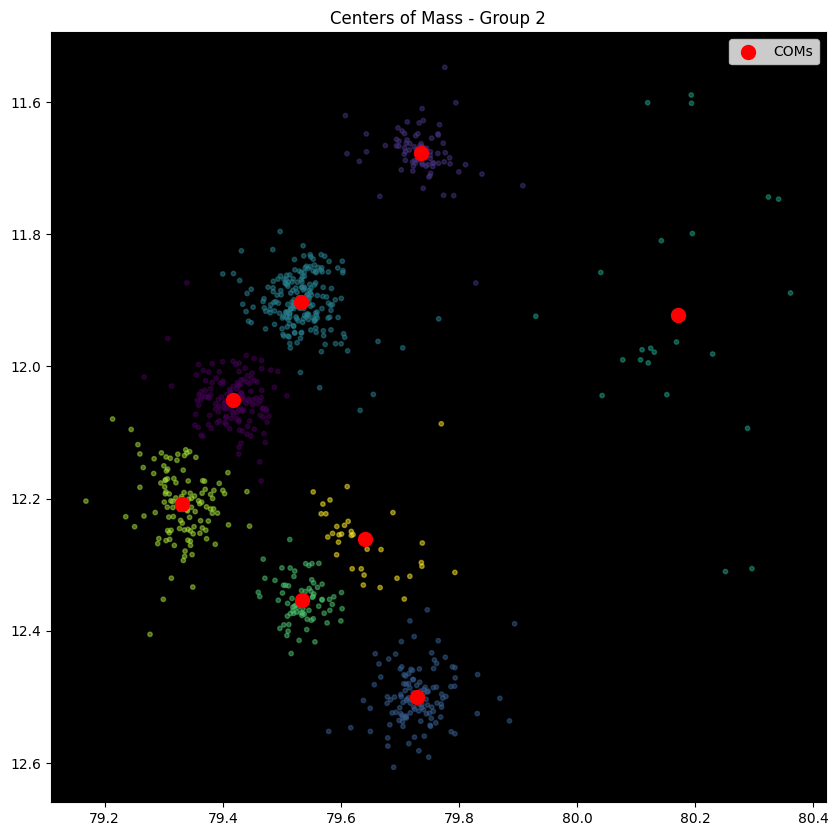

Minimum Bounding Rectangle:
 [[80.17131507 11.92180381]
 [79.74002725 11.60731889]
 [79.31145317 12.19506975]
 [79.742741   12.50955466]]
Closest side of bounding rectangle:
 1
Closest line start: [79.74002725 11.60731889], end: [79.31145317 12.19506975]
Initial calculated angle: 2.2008366107386013 radians (126.09864919319828 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.342429264328395 radians (306.0986491931983 degrees)
Final rotation angle: -5.342429264328395 radians (-306.0986491931983 degrees)
Rotation angle:
 -5.342429264328395
Rotated Data:
 [[79.72641128 12.22309349]
 [79.70498875 12.16292114]
 [79.67161286 12.13319158]
 [79.65129489 12.14287037]
 [79.67045987 12.14158613]]
Rotated Centers of Mass (COM):
 [[79.19209136 11.60731889]
 [79.68080763 11.644872  ]
 [79.01261622 12.12430908]
 [79.37936448 11.6142531 ]
 [79.74002725 12.14108846]
 [79.01560683 11.88117692]
 [79.01261622 11.63064647]
 [79.1524663  11.91211456]]
Final rotation angle after adjustment: -5.3424

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


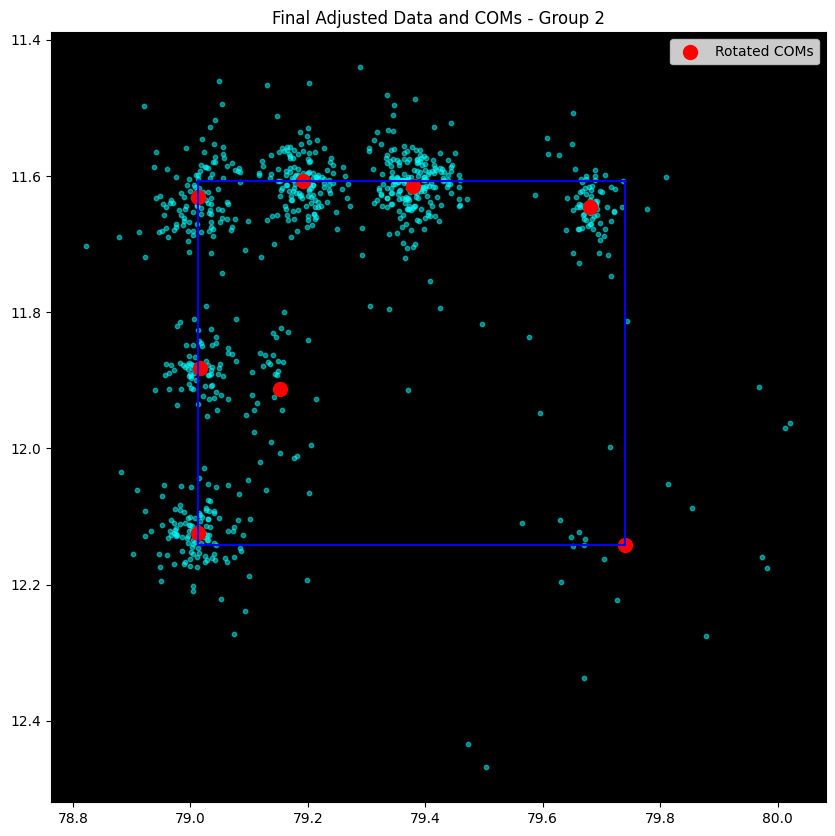

Second Highest COM:
 [79.01560683 11.88117692]
Right Most COM:
 [79.74002725 12.14108846]
Second Right Most COM:
 [79.68080763 11.644872  ]
Robot COM:
 [79.1524663  11.91211456]


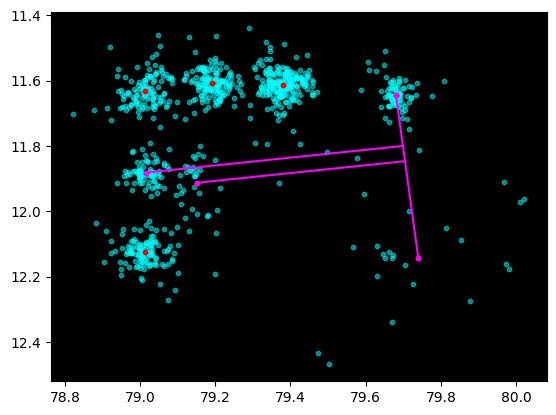

Ratio:
 0.8079507924373667

Processing Group 3
Data collected:
            x         y
0  96.276115  5.262790
1  96.280777  5.182926
2  96.253075  5.196754
3  96.216118  5.205290
4  96.236908  5.174649


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


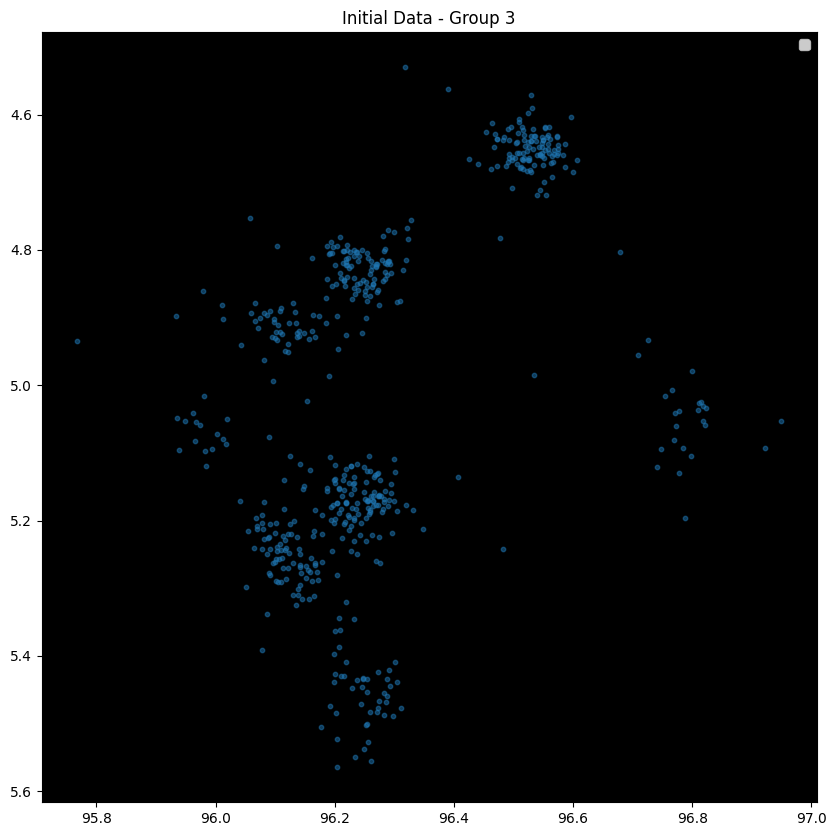

K-Means labels:
 [1 1 1 1 1 0 0 0 0 0 0 0 0 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 3 6 6 6 2
 2 2 2 2 2 7 7 7 6 6 6 2 2 2 2 5 5 5 5 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 6 6 6 6 6 6 6 6 1 1 2 2 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 7 0 0 0 0 0 0 0
 2 2 0 0 0 0 0 2 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 5 5
 5 5 5 1 6 6 6 4 4 4 4 1 4 1 6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 1 1 6 1 6 6 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 6 6 5 5
 5 5 5 7 7 6 1 1 5 6 6 6 1 1 7 7 7 7 6 1 1 1 1 1 1 1 1 1 1 1 7 7 7 7 7 7 1
 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 4 4 4 5 5 5 5 5 6 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 5 5 5 5 5 5 5 6 6
 1 6 6 1 1 1 1 4 4 4 6 6 6 1 1 4 1 1 1 3 0 0 0 0 0 0 0 1 3 3 0 0 1 1 7 1 1
 1 1 3 3 3 1 1 1 1 3 3 3 4 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 3 6 6

/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


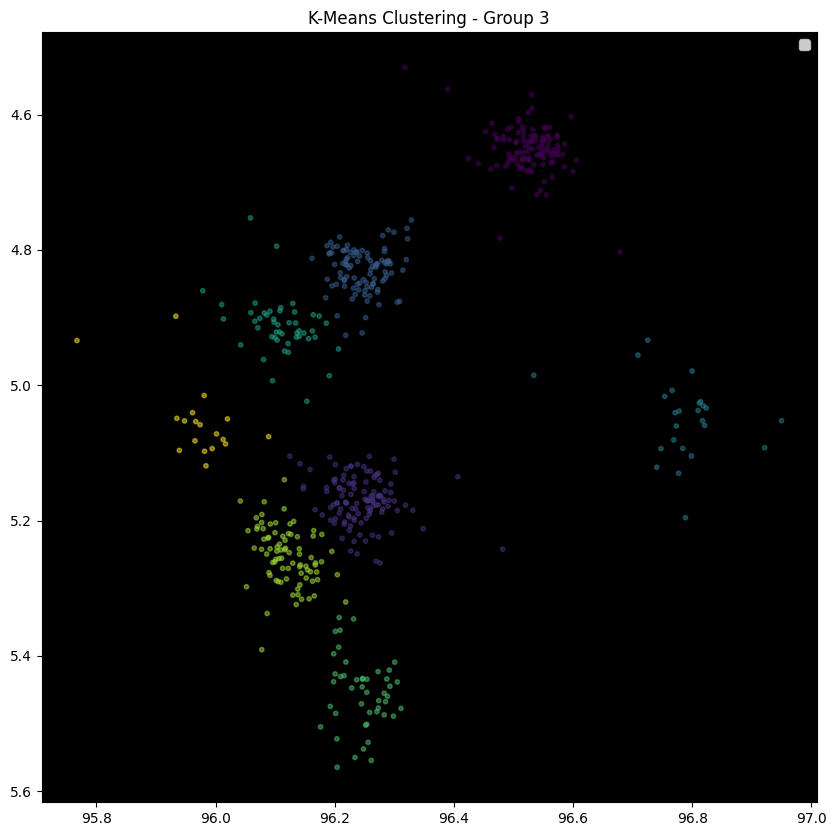

Centers of Mass (COM):
 [(np.float64(96.52659242343059), np.float64(4.651792268837448)), (np.float64(96.24395824300832), np.float64(5.169995365471675)), (np.float64(96.2470948961046), np.float64(4.829189396867848)), (np.float64(96.78432647705078), np.float64(5.049751472473145)), (np.float64(96.10949961344402), np.float64(4.912443409363429)), (np.float64(96.24598710433297), np.float64(5.454964492631995)), (np.float64(96.12027545091583), np.float64(5.252703178219679)), (np.float64(95.97059546576605), np.float64(5.053029855092366))]


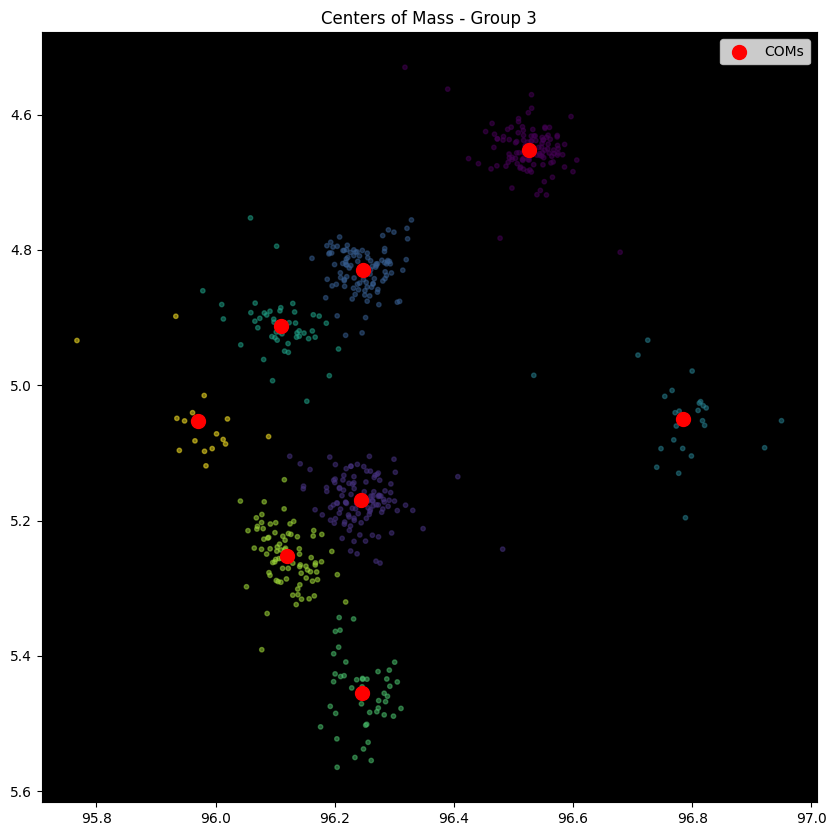

Minimum Bounding Rectangle:
 [[96.81144371  5.06753329]
 [96.51487669  4.63469313]
 [95.94942008  5.02212434]
 [96.2459871   5.45496449]]
Closest side of bounding rectangle:
 1
Closest line start: [96.51487669  4.63469313], end: [95.94942008  5.02212434]
Initial calculated angle: 2.540892449851184 radians (145.582413573129 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.6824851034409765 radians (325.582413573129 degrees)
Final rotation angle: -5.6824851034409765 radians (-325.582413573129 degrees)
Rotation angle:
 -5.6824851034409765
Rotated Data:
 [[95.96289978  5.01788286]
 [96.01188632  4.95463424]
 [95.98121726  4.95038421]
 [95.94590549  4.93653706]
 [95.9803753   4.9230106 ]]
Rotated Centers of Mass (COM):
 [[96.51487669  4.65542086]
 [95.98882156  4.92315679]
 [96.18403954  4.6437852 ]
 [96.50255724  5.12938985]
 [96.02347483  4.63469313]
 [95.82942493  5.15938599]
 [95.84004254  4.92147776]
 [95.82942493  4.67215709]]
Final rotation angle after adjustment: -5.682485

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


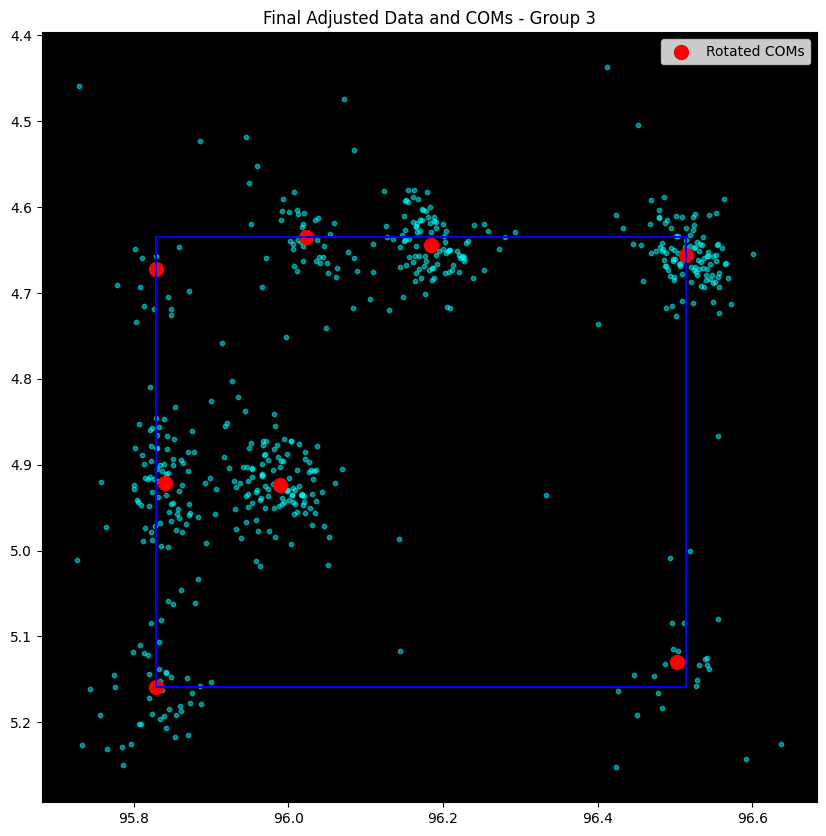

Second Highest COM:
 [95.84004254  4.92147776]
Right Most COM:
 [96.51487669  4.65542086]
Second Right Most COM:
 [96.50255724  5.12938985]
Robot COM:
 [95.98882156  4.92315679]


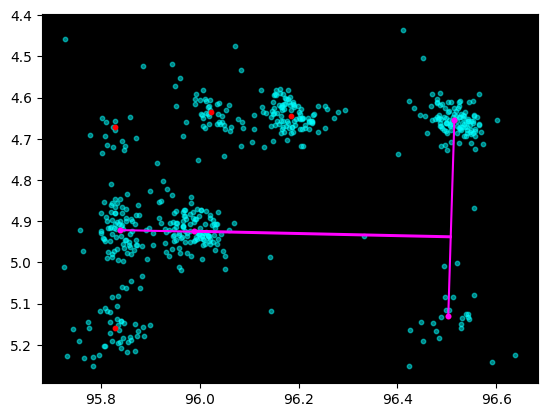

Ratio:
 0.7771844927893748

Processing Group 4
Data collected:
             x          y
0  154.937286  12.149701
1  154.065964  12.067630
2  154.442245  12.426337
3  154.473663  12.418509
4  154.446823  12.387403


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


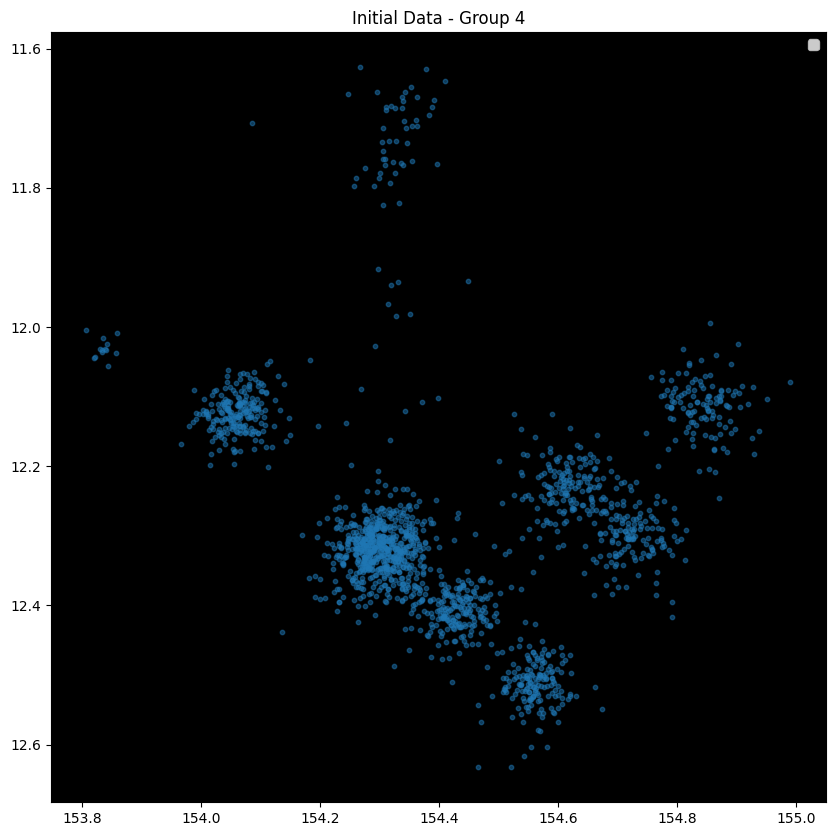

K-Means labels:
 [3 2 0 ... 7 7 7]


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


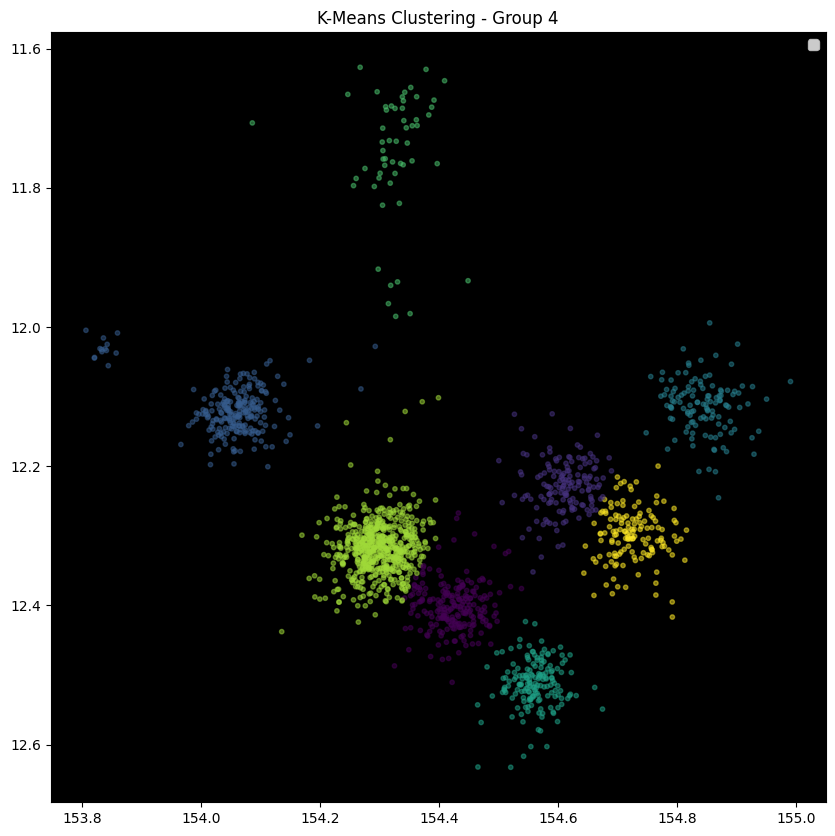

Centers of Mass (COM):
 [(np.float64(154.42420697104336), np.float64(12.40173018787781)), (np.float64(154.6097392032021), np.float64(12.228787083374826)), (np.float64(154.05118603727), np.float64(12.117638014095686)), (np.float64(154.84418657791517), np.float64(12.113616872424922)), (np.float64(154.56031336103166), np.float64(12.51306314695449)), (np.float64(154.32502330433238), np.float64(11.752556471391157)), (np.float64(154.29775283966575), np.float64(12.317333513279024)), (np.float64(154.72505798339844), np.float64(12.299547467912946))]


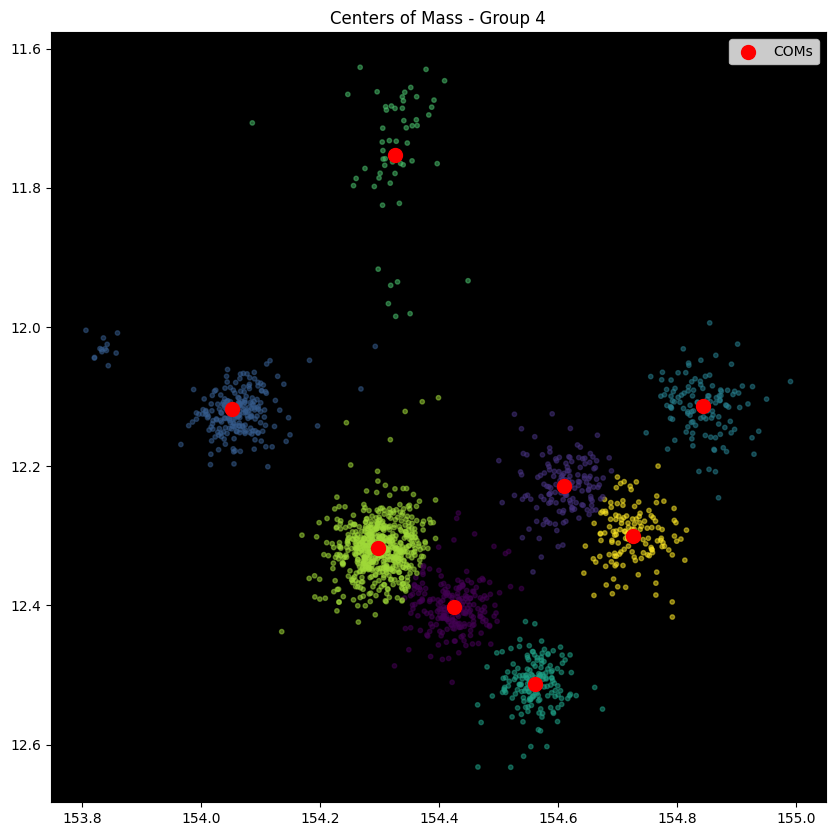

Minimum Bounding Rectangle:
 [[154.85670564  12.12294939]
 [154.33638052  11.73506532]
 [154.04357257  12.12785106]
 [154.56389768  12.51573513]]
Closest side of bounding rectangle:
 2
Closest line start: [154.04357257  12.12785106], end: [154.56389768  12.51573513]
Initial calculated angle: 0.6405922741606443 radians (36.70323369809226 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.7821849277504374 radians (216.70323369809225 degrees)
Final rotation angle: -3.7821849277504374 radians (-216.70323369809225 degrees)
Rotation angle:
 -3.7821849277504374
Rotated Data:
 [[153.31398562  12.64447924]
 [154.06161308  12.1895155 ]
 [153.54554343  12.12681718]
 [153.52503342  12.1518713 ]
 [153.56514347  12.16076868]]
Rotated Centers of Mass (COM):
 [[153.57471257  12.1357646 ]
 [153.52932658  12.38530746]
 [154.04357257  12.14058963]
 [153.41019412  12.6177665 ]
 [153.39904996  12.12785106]
 [154.04222419  12.59695524]
 [153.72653754  12.12785106]
 [153.39457929  12.39749851]]
Fina

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


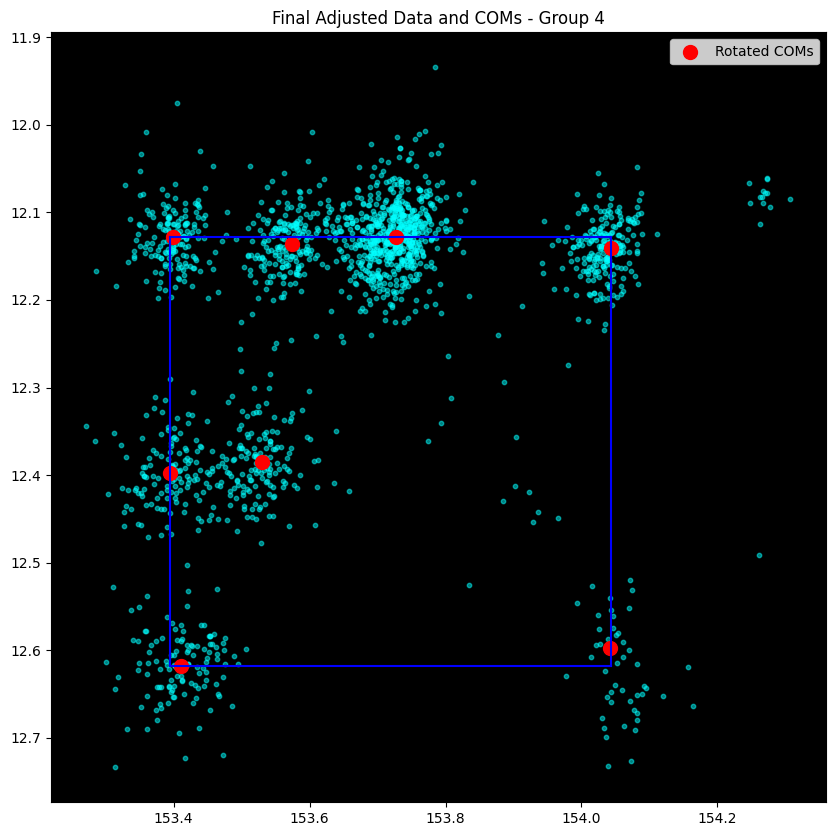

Second Highest COM:
 [153.39457929  12.39749851]
Right Most COM:
 [154.04357257  12.14058963]
Second Right Most COM:
 [154.04222419  12.59695524]
Robot COM:
 [153.52932658  12.38530746]


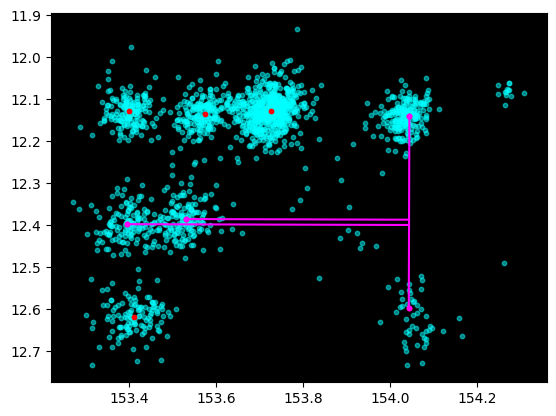

Ratio:
 0.7921873542907827

Processing Group 5
Data collected:
             x          y
0  190.320480  16.102219
1  190.276398  16.173414
2  190.258575  16.114859
3  190.139954  16.050495
4  190.059372  16.388666


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


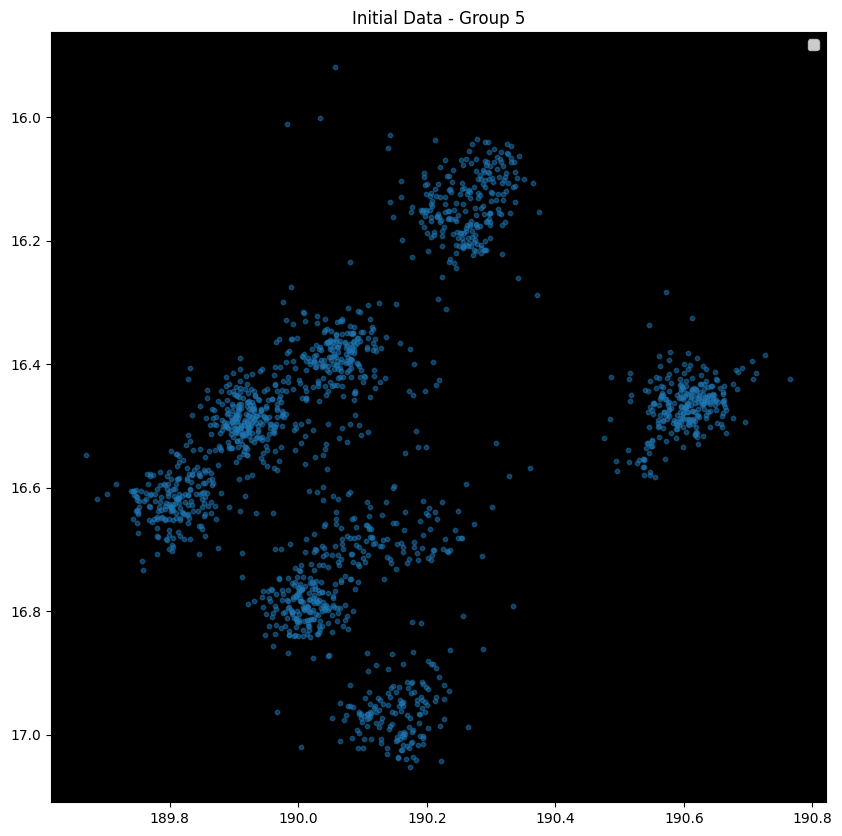

/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


K-Means labels:
 [2 2 2 ... 4 4 4]


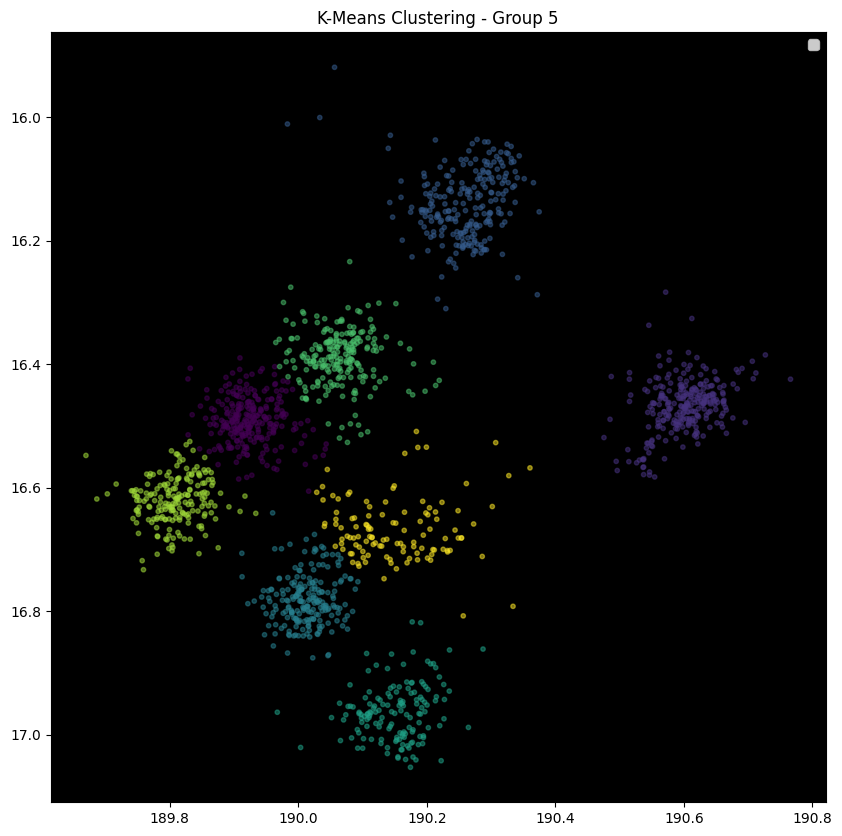

Centers of Mass (COM):
 [(np.float64(189.92462289645877), np.float64(16.49041497305538)), (np.float64(190.60105555651356), np.float64(16.46740259645597)), (np.float64(190.25993032823817), np.float64(16.14046060783157)), (np.float64(190.01223790701567), np.float64(16.78151156644866)), (np.float64(190.1514623245137), np.float64(16.963087056307184)), (np.float64(190.0642186505762), np.float64(16.389368635496943)), (np.float64(189.808189002835), np.float64(16.620651176997594)), (np.float64(190.1504442938443), np.float64(16.667047829463563))]


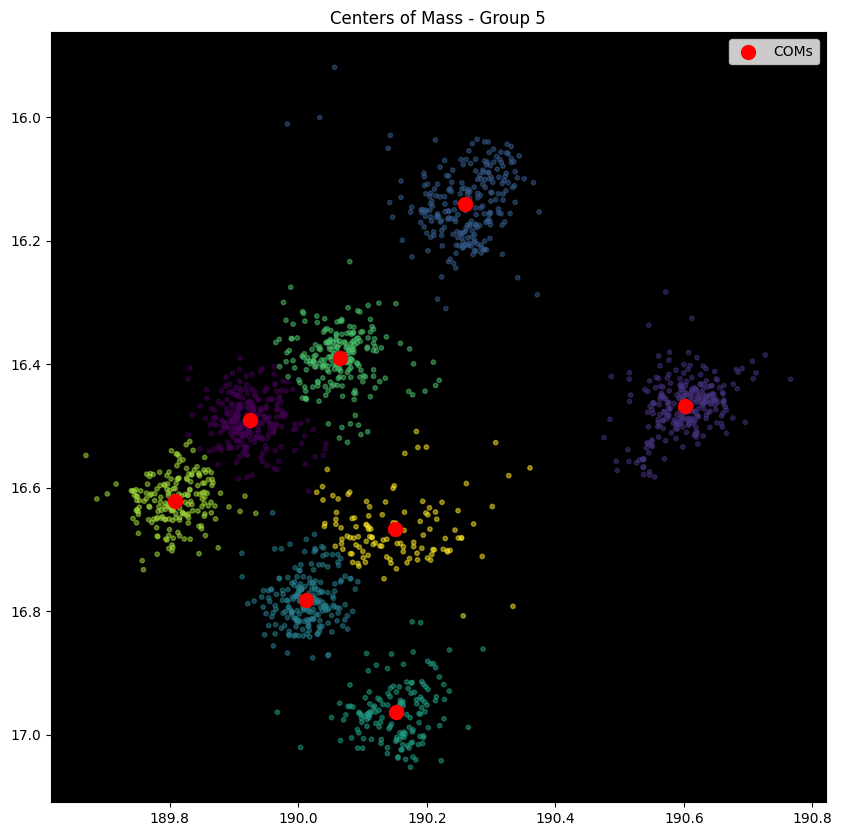

Minimum Bounding Rectangle:
 [[190.61431654  16.4800144 ]
 [190.25993033  16.14046061]
 [189.79707611  16.62353327]
 [190.15146232  16.96308706]]
Closest side of bounding rectangle:
 1
Closest line start: [190.25993033  16.14046061], end: [189.79707611  16.62353327]
Initial calculated angle: 2.3348235286107104 radians (133.77553409723612 degrees)
Adjusted angle by 180 degrees (for bottom side): 5.476416182200504 radians (313.7755340972361 degrees)
Final rotation angle: -5.476416182200504 radians (-313.7755340972361 degrees)
Rotation angle:
 -5.476416182200504
Rotated Data:
 [[190.32943379  16.15772396]
 [190.24752868  16.17514944]
 [190.27747903  16.12176996]
 [190.24188632  15.99158949]
 [189.94195881  16.16736354]]
Rotated Centers of Mass (COM):
 [[189.77526639  16.14046061]
 [190.25986234  16.61296191]
 [190.25993033  16.14046061]
 [189.62569356  16.40511431]
 [189.59090625  16.63126236]
 [189.94480469  16.17134914]
 [189.60067556  16.1464908 ]
 [189.80395875  16.42571701]]
Final ro

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


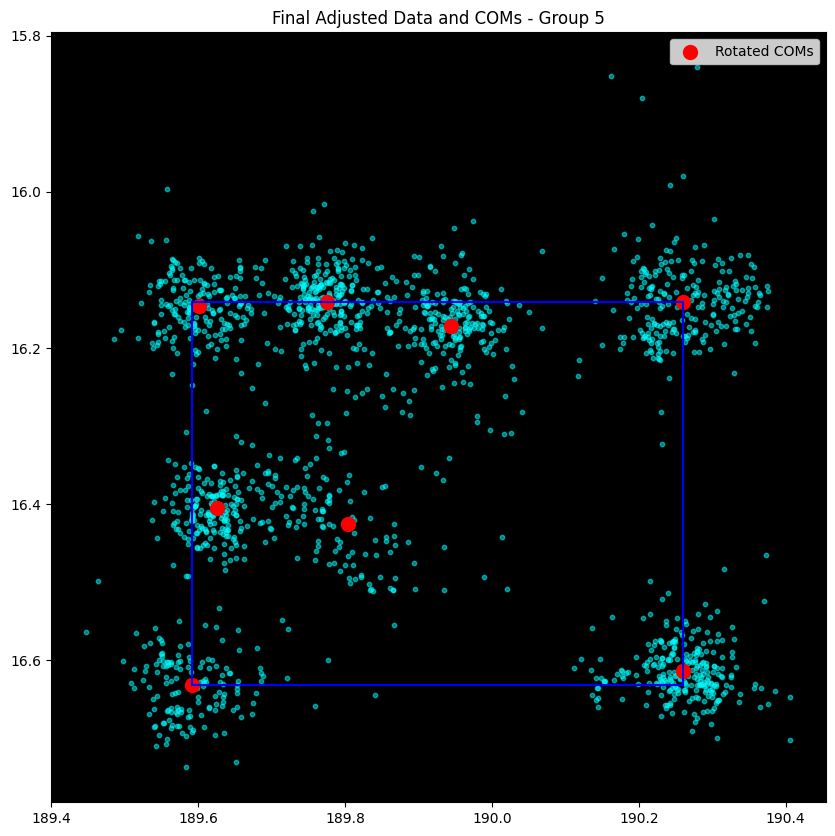

Second Highest COM:
 [189.62569356  16.40511431]
Right Most COM:
 [190.25993033  16.14046061]
Second Right Most COM:
 [190.25986234  16.61296191]
Robot COM:
 [189.80395875  16.42571701]


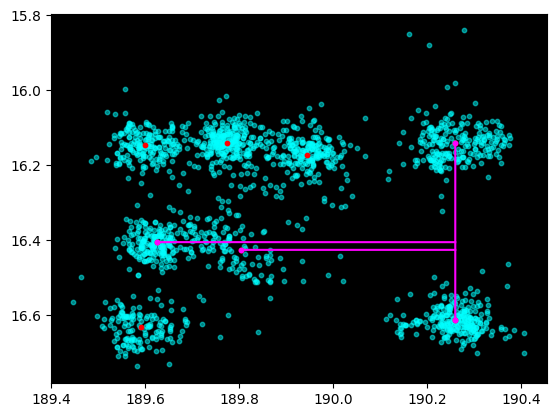

Ratio:
 0.7189080236984043

Processing Group 6
Data collected:
             x         y
0  192.853226  3.511629
1  192.808411  3.494667
2  192.990067  3.477808
3  192.797516  3.549601
4  192.846237  3.472739


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


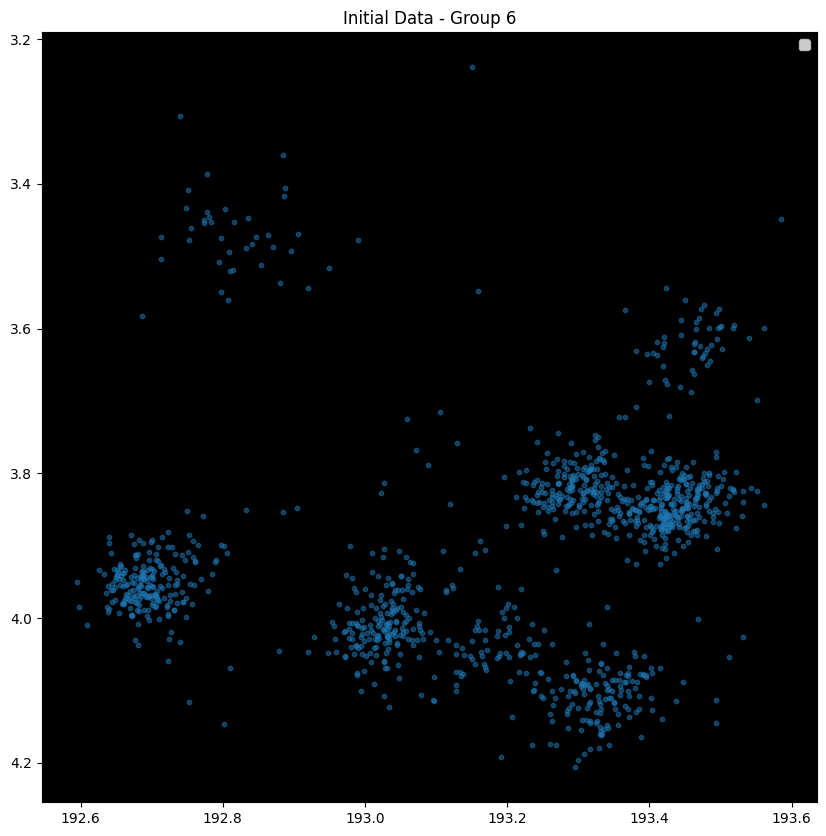

K-Means labels:
 [4 4 4 ... 5 5 1]


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


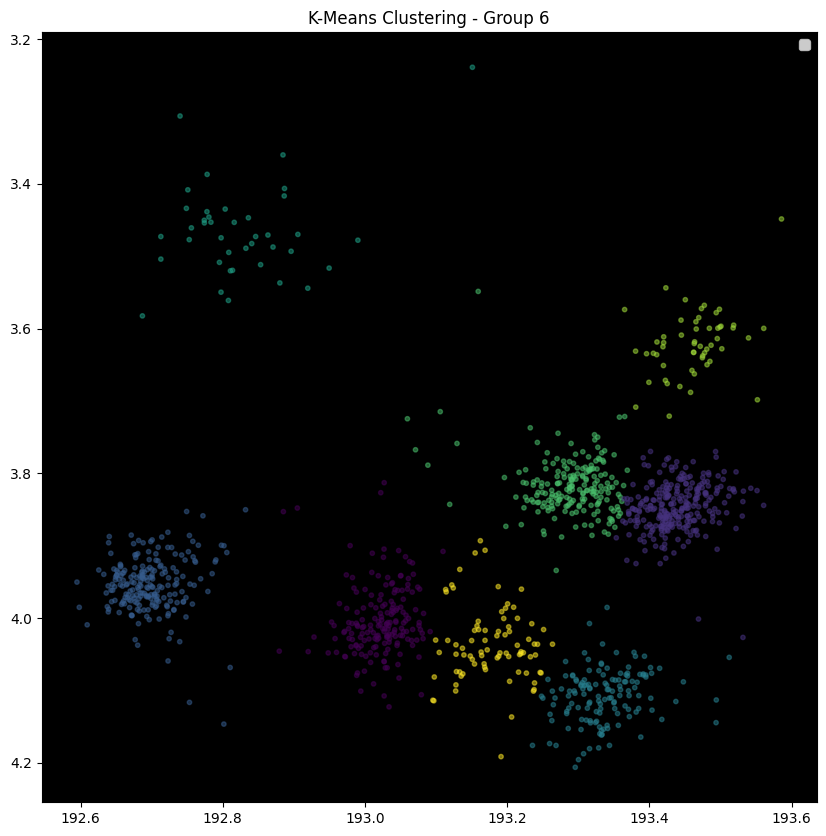

Centers of Mass (COM):
 [(np.float64(193.02164210535545), np.float64(4.003581663521614)), (np.float64(193.43850013925712), np.float64(3.8464720576248443)), (np.float64(192.69750955071248), np.float64(3.9537883241411667)), (np.float64(193.33668298515485), np.float64(4.107724654588768)), (np.float64(192.82681579589843), np.float64(3.46524173617363)), (np.float64(193.2893615415947), np.float64(3.8175938009616717)), (np.float64(193.4624910707827), np.float64(3.620672071421588)), (np.float64(193.17829009633004), np.float64(4.0361552238464355))]


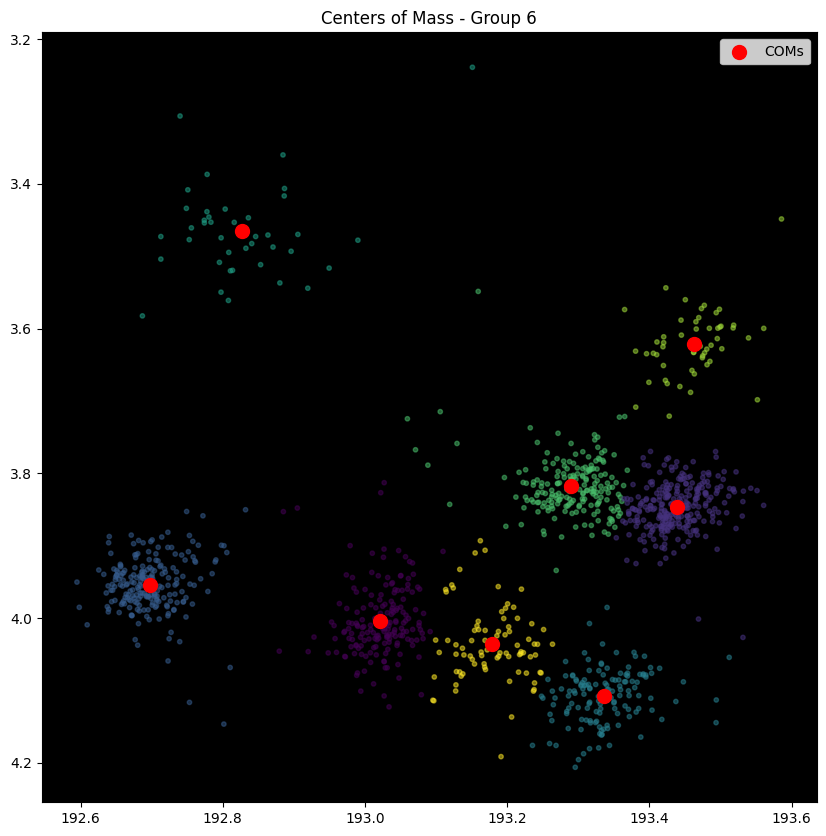

Minimum Bounding Rectangle:
 [[193.49194976   3.62787508]
 [192.81752084   3.46296901]
 [192.69750955   3.95378832]
 [193.37193847   4.1186944 ]]
Closest side of bounding rectangle:
 2
Closest line start: [192.69750955   3.95378832], end: [193.37193847   4.1186944 ]
Initial calculated angle: 0.23980700643578945 radians (13.739929366437305 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.3813996600255827 radians (193.7399293664373 degrees)
Final rotation angle: -3.3813996600255827 radians (-193.7399293664373 degrees)
Rotation angle:
 -3.3813996600255827
Rotated Data:
 [[192.65126885   4.42027936]
 [192.69883028   4.42611199]
 [192.52637686   4.48563417]
 [192.69636563   4.3701623 ]
 [192.6672945    4.45639718]]
Rotated Centers of Mass (COM):
 [[192.37082575   3.98240627]
 [192.00321251   4.23403011]
 [192.69750955   3.95378832]
 [192.0400646    3.95607044]
 [192.68794078   4.45906677]
 [192.15494236   4.2266593 ]
 [192.03353903   4.45906677]
 [192.21092371   3.98797112]]
Fina

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


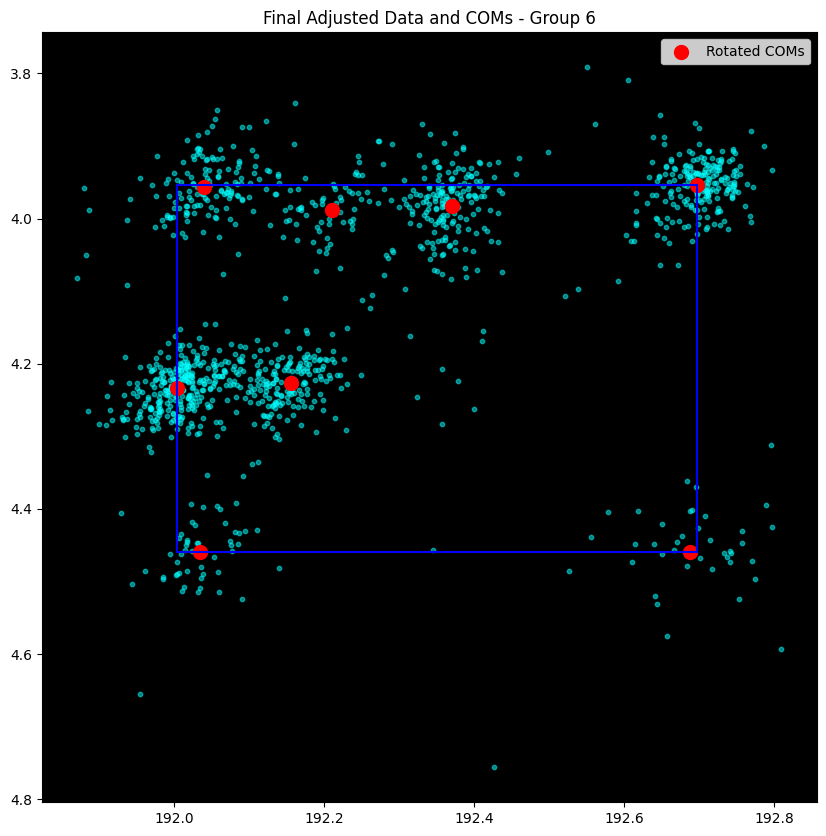

Second Highest COM:
 [192.00321251   4.23403011]
Right Most COM:
 [192.69750955   3.95378832]
Second Right Most COM:
 [192.68794078   4.45906677]
Robot COM:
 [192.15494236   4.2266593 ]


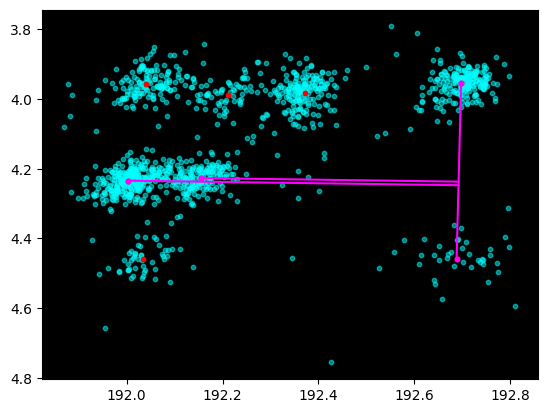

Ratio:
 0.7799818899101107

Processing Group 7
Data collected:
             x          y
0  223.384872  14.570362
1  223.379608  14.605626
2  223.415466  14.562952
3  223.395050  14.599780
4  223.444214  14.630434


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


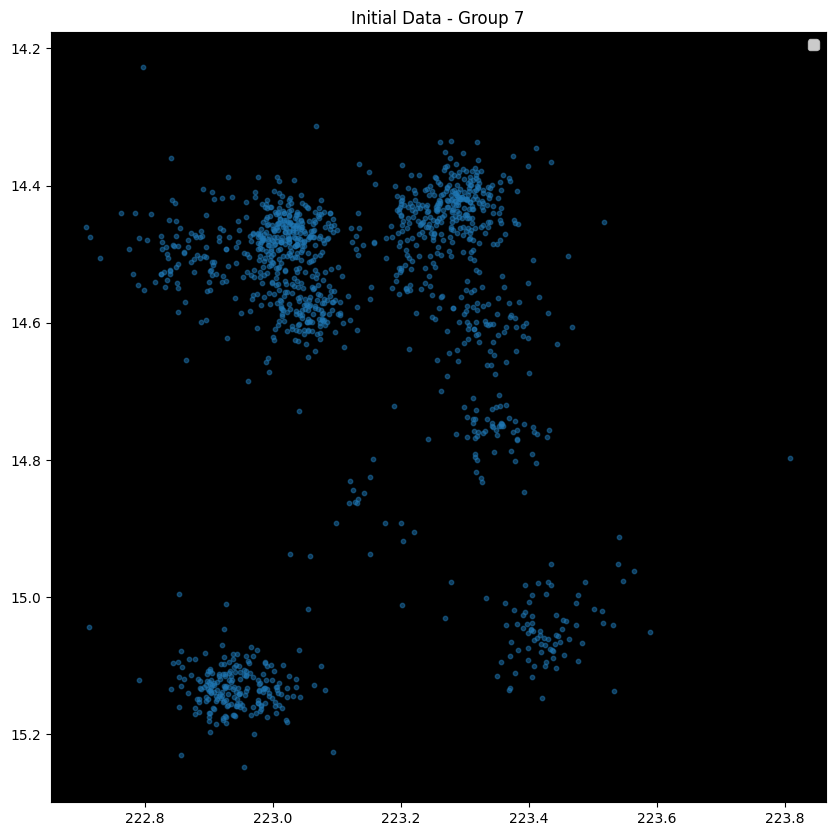

K-Means labels:
 [7 7 7 ... 3 2 4]


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


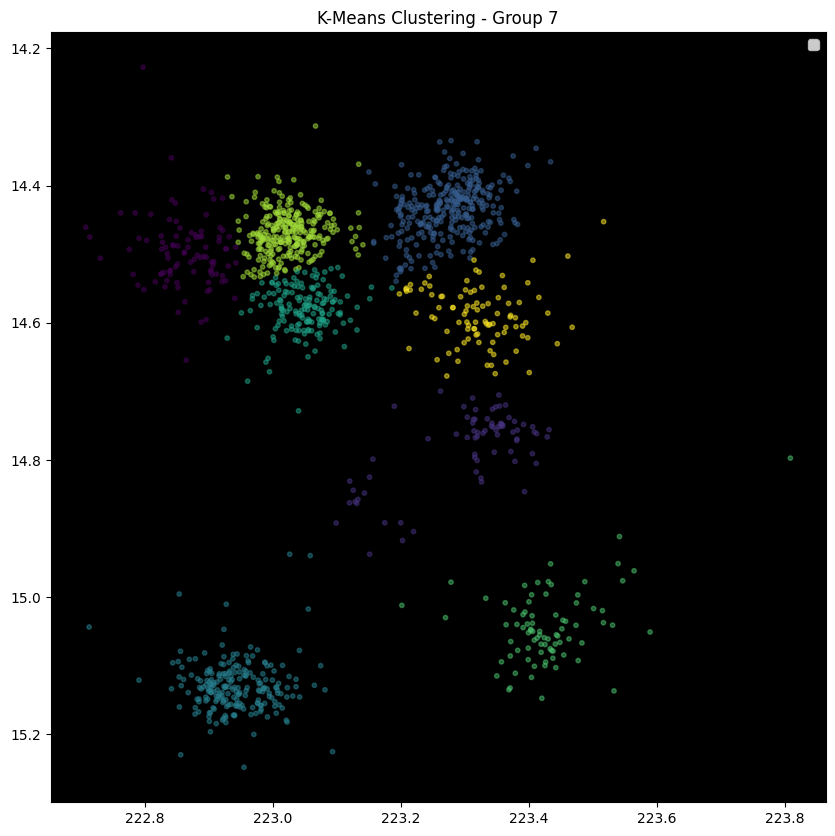

Centers of Mass (COM):
 [(np.float64(222.86249915589678), np.float64(14.496709935208584)), (np.float64(223.30488359605943), np.float64(14.781124321190086)), (np.float64(223.27476365045206), np.float64(14.434383297598124)), (np.float64(222.94146528867918), np.float64(15.129941155977338)), (np.float64(223.04856458122347), np.float64(14.579886047928422)), (np.float64(223.42969177990426), np.float64(15.043157368171507)), (np.float64(223.02327102551357), np.float64(14.468674906723791)), (np.float64(223.32092236457987), np.float64(14.588685634288382))]


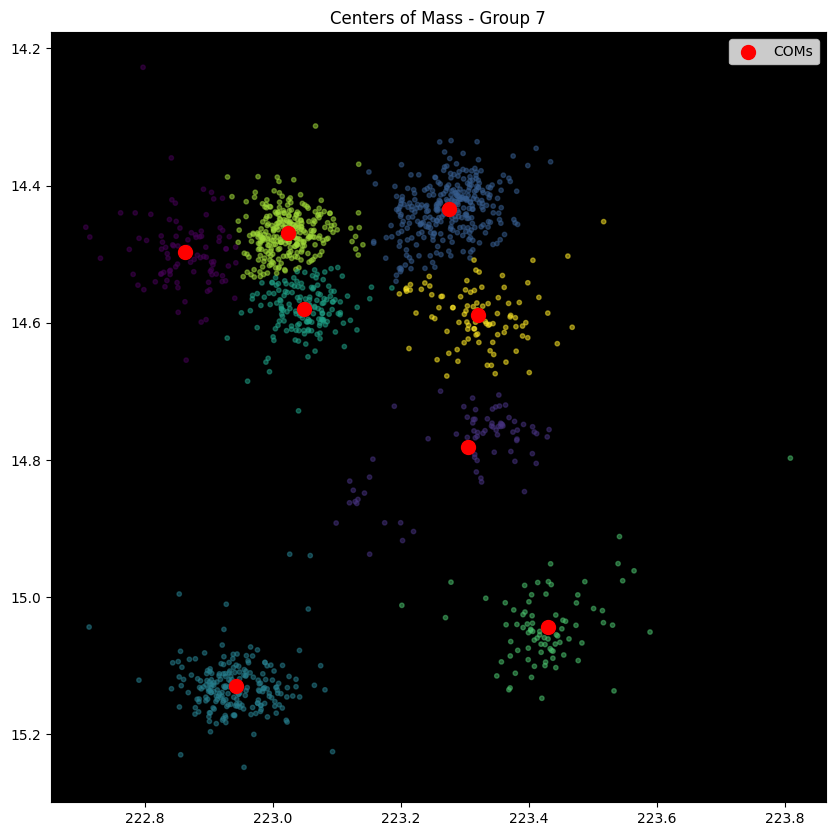

Minimum Bounding Rectangle:
 [[223.42997067  15.04475671]
 [223.32047752  14.41684872]
 [222.83197214  14.50203317]
 [222.94146529  15.12994116]]
Closest side of bounding rectangle:
 0
Closest line start: [223.42997067  15.04475671], end: [223.32047752  14.41684872]
Initial calculated angle: -1.7434381189476014 radians (-99.89164605792476 degrees)
Final rotation angle: 1.7434381189476014 radians (99.89164605792476 degrees)
Rotation angle:
 1.7434381189476014
Rotated Data:
 [[223.90506034  15.08182299]
 [223.87122488  15.07057912]
 [223.90710466  15.11323501]
 [223.8743313   15.08679573]
 [223.83568741  15.12996279]]
Rotated Centers of Mass (COM):
 [[224.06735375  14.57986748]
 [223.71117214  14.96681735]
 [224.05793282  14.99671022]
 [223.42997067  14.54887982]
 [223.95345077  14.74887848]
 [223.43159415  15.04475671]
 [224.06735375  14.74306539]
 [223.89799488  15.01567586]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 4.8850307725373945 radians (279.89164605792473 

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


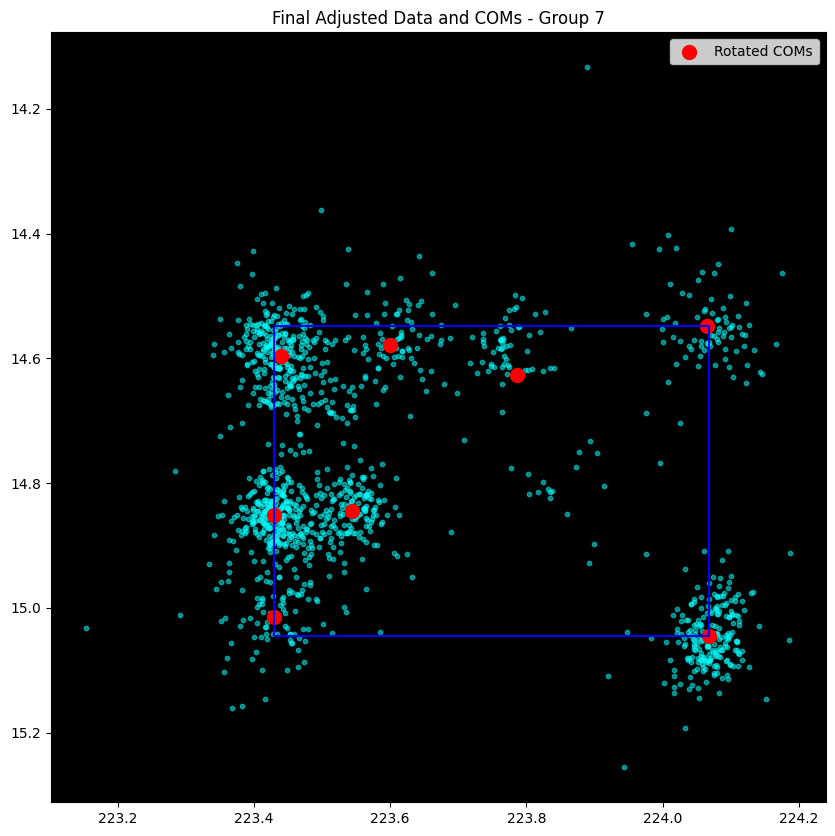

Second Highest COM:
 [223.42997067  14.85057114]
Right Most COM:
 [224.06735375  15.04475671]
Second Right Most COM:
 [224.06573027  14.54887982]
Robot COM:
 [223.54387365  14.84475804]


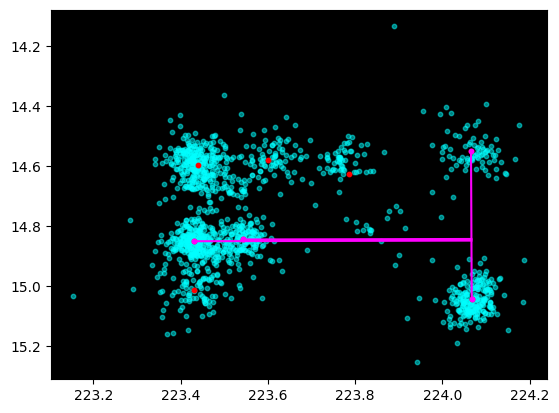

Ratio:
 0.8210875630767464

Processing Group 8
Data collected:
             x         y
0  237.977173  6.251901
1  238.027069  6.185611
2  238.016663  6.100646
3  238.483246  5.802577
4  238.440857  5.771270


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


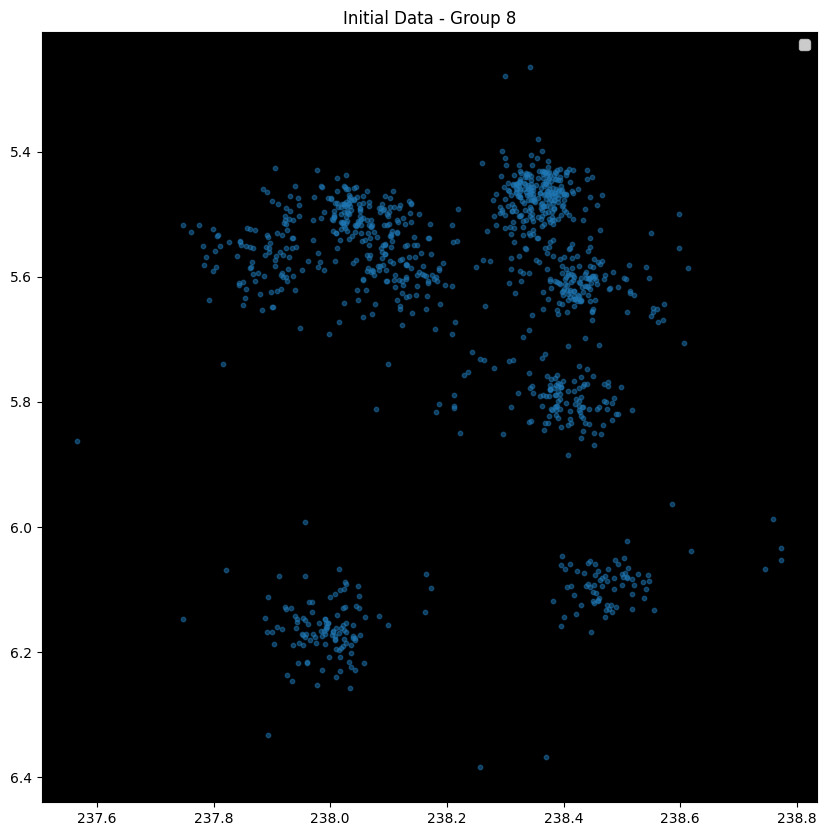

K-Means labels:
 [2 2 2 ... 1 1 1]


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


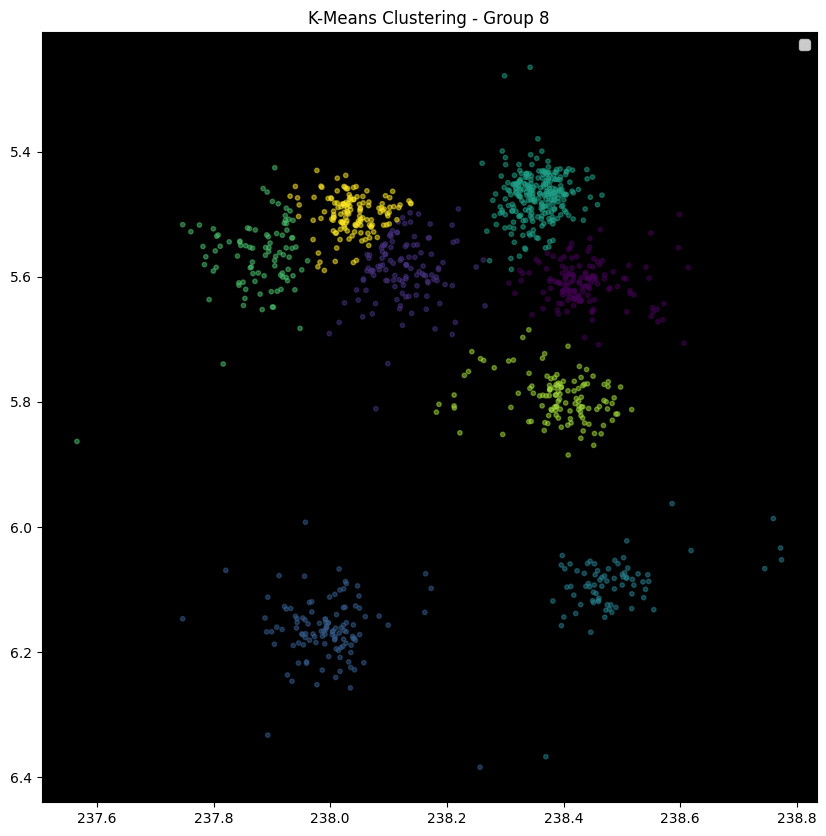

Centers of Mass (COM):
 [(np.float64(238.4365927956321), np.float64(5.611138427174175)), (np.float64(238.12686875287224), np.float64(5.590715764951305)), (np.float64(237.99338153341543), np.float64(6.164132669697637)), (np.float64(238.48725077311198), np.float64(6.092408180236816)), (np.float64(238.3551462809245), np.float64(5.471050802866618)), (np.float64(237.87650415171748), np.float64(5.568273876024329)), (np.float64(238.3882244519951), np.float64(5.793326519737559)), (np.float64(238.0382994507714), np.float64(5.500531272064868))]


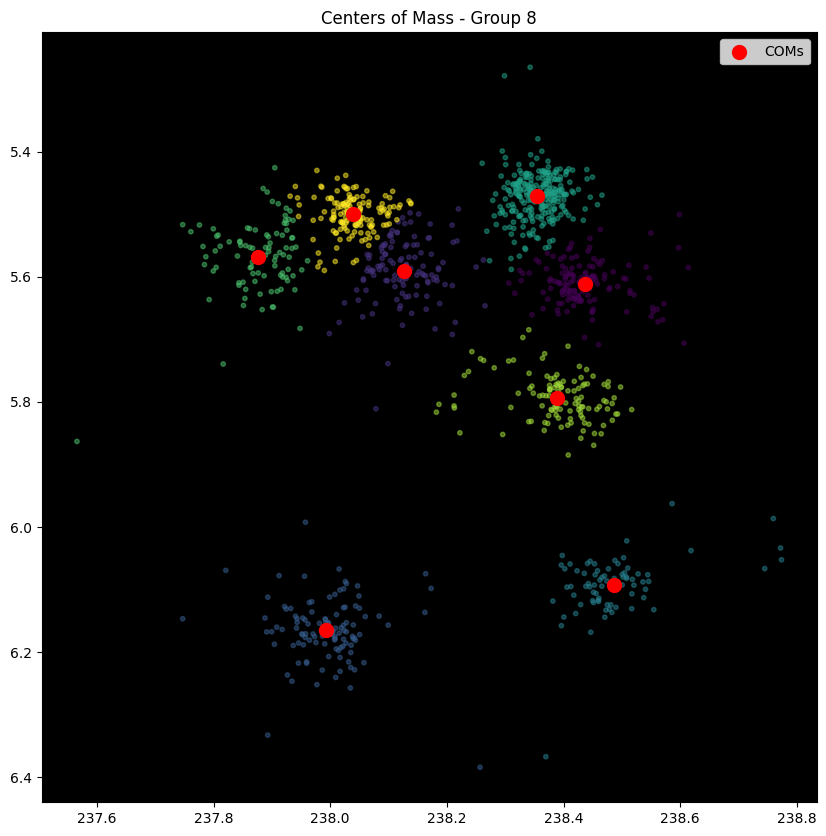

Minimum Bounding Rectangle:
 [[238.52937296   6.08414594]
 [238.40094463   5.42939862]
 [237.86970315   5.53360135]
 [237.99813149   6.18834866]]
Closest side of bounding rectangle:
 0
Closest line start: [238.52937296   6.08414594], end: [238.40094463   5.42939862]
Initial calculated angle: -1.764486719394605 radians (-101.09764202819525 degrees)
Final rotation angle: 1.764486719394605 radians (101.09764202819525 degrees)
Rotation angle:
 1.764486719394605
Rotated Data:
 [[238.47104349   5.50998194]
 [238.5264897    5.57170474]
 [238.61186919   5.57784708]
 [238.81455486   6.09307811]
 [238.85343574   6.0575079 ]]
Rotated Centers of Mass (COM):
 [[239.01139398   6.08414594]
 [239.09105093   5.78414454]
 [238.55405041   5.54278126]
 [238.52937296   6.04122107]
 [239.164539     6.03118671]
 [239.16126374   5.54278126]
 [238.84192272   6.0016142 ]
 [239.19659698   5.71459028]]
Adjusting by 180 degrees
Final rotation angle after adjustment: 4.906079372984398 radians (281.09764202819525 de

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


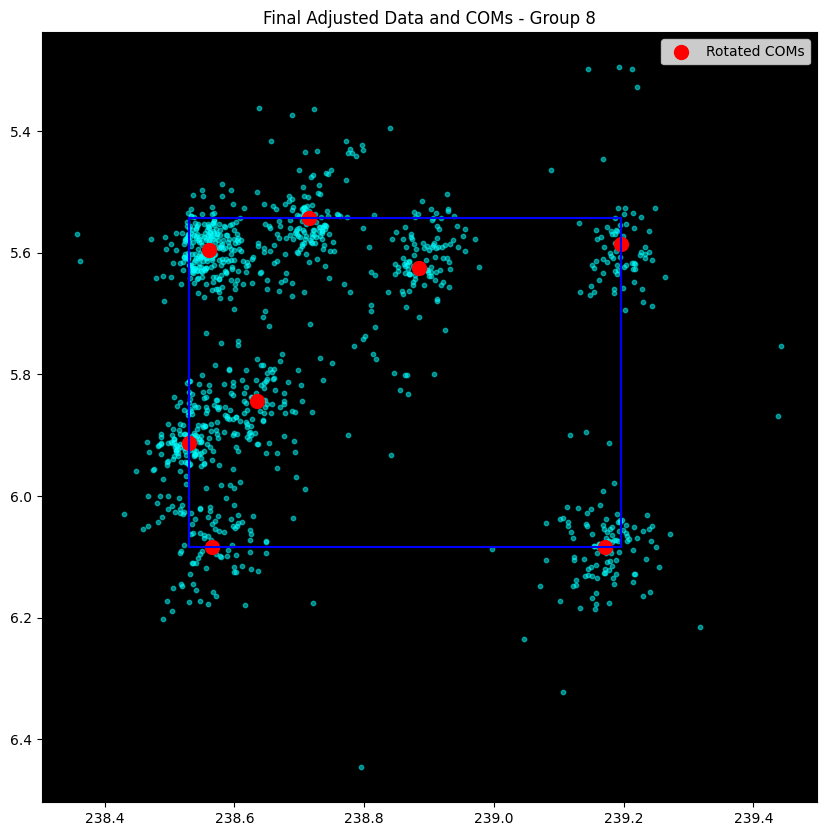

Second Highest COM:
 [238.52937296   5.91233691]
Right Most COM:
 [239.19659698   5.58570612]
Second Right Most COM:
 [239.17191953   6.08414594]
Robot COM:
 [238.63491902   5.84278266]


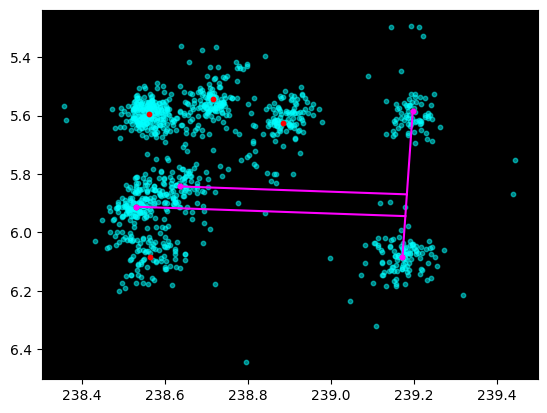

Ratio:
 0.8431732755861153

Processing Group 9
Data collected:
             x          y
0  204.727203  23.444227
1  204.673523  23.472221
2  204.732361  23.457150
3  204.768372  23.501686
4  205.214050  22.981375


/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


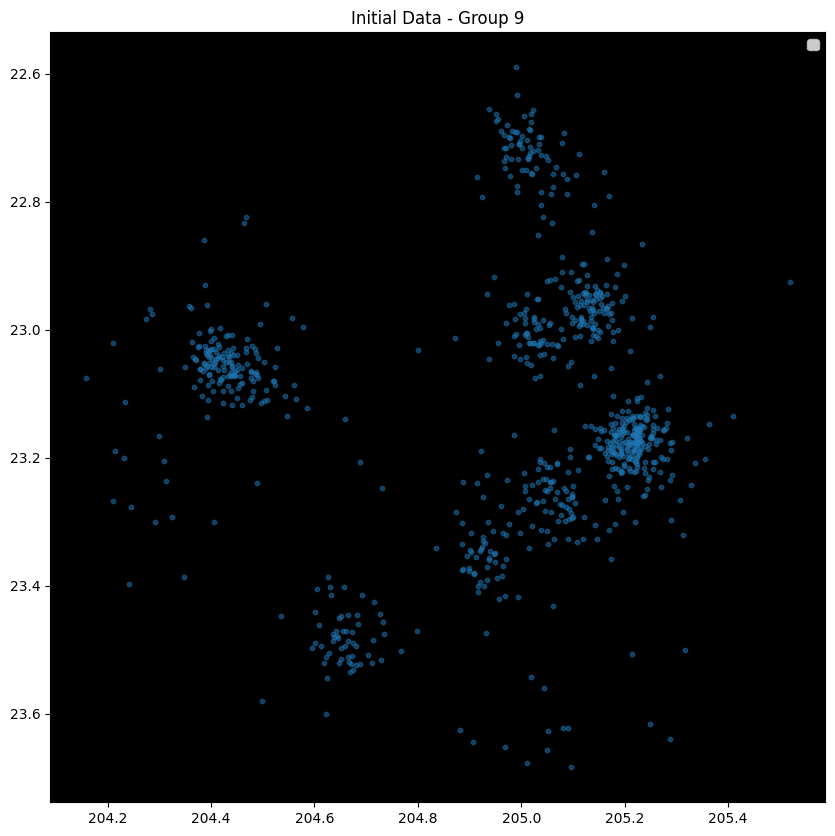

K-Means labels:
 [4 4 4 4 2 2 2 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 3 0 0 0 0 0 0 0 0 3 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 2 2 0 4 4 4 0 0 0 0 0 0 0 1 1 1 1
 1 1 7 7 2 2 2 0 3 0 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 3 3 3 3 3 1
 1 1 1 1 7 1 1 1 1 3 3 3 3 3 3 3 3 3 3 6 4 4 4 4 4 4 4 4 4 4 6 4 0 6 6 6 6
 6 6 6 6 6 6 6 6 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 1 2
 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 5 2 2 2 2 2 2 2 7 2 2 5 5 4 4 2 2 2 3
 3 1 1 1 1 1 1 1 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 4 3 3 2 2 2 4 4 4 4 1 1 1 1 1 1 1 5 5 5 4 4 1 1 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 1 7 1 5 5 5 4 4 4 5 5 5 5 5 0 0 0 0 2 2 3 3 3 3 2 3 7 1 1 1 1 1 1
 1 1 1 1 1 1 2 1 1 1 1 1 1 3 0 3 3 0 0 0 0 0 7 7 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 5 5 2 2 0 3 0 2 2 1 1 1 1 1
 1 1 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 5 5 5 5 5 5 5
 5 5 5 5

/tmp/ipykernel_9597/3141059507.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


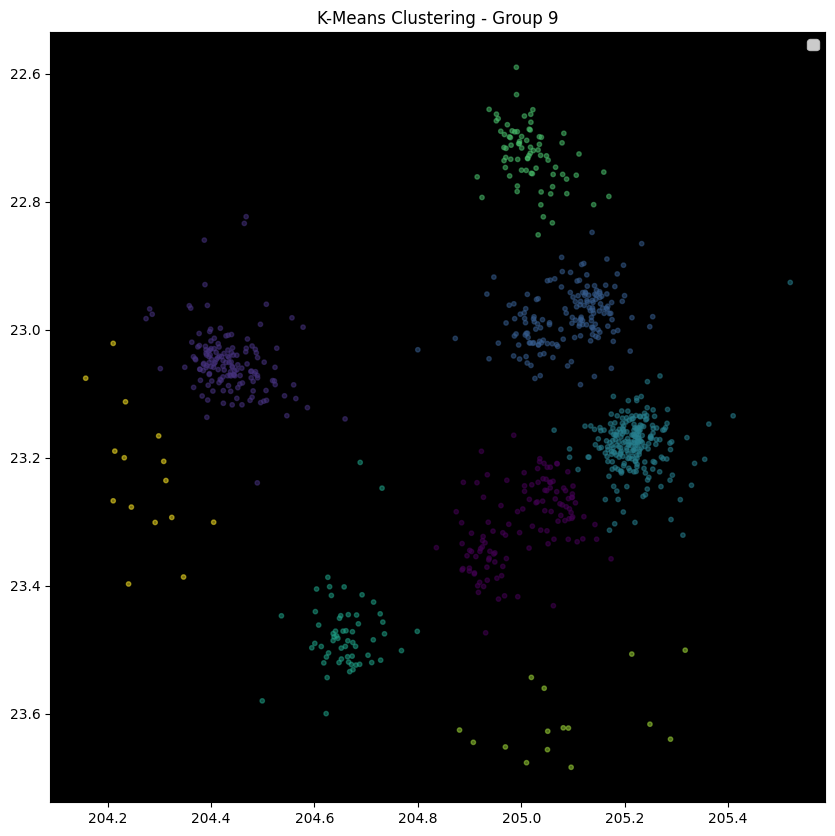

Centers of Mass (COM):
 [(np.float64(205.00301615397134), np.float64(23.30264770189921)), (np.float64(204.43523579915365), np.float64(23.051091740926108)), (np.float64(205.0923733594941), np.float64(22.98025301026135)), (np.float64(205.217156162346), np.float64(23.179604450511512)), (np.float64(204.6600561626887), np.float64(23.47455044116004)), (np.float64(205.01724604556435), np.float64(22.726969543256256)), (np.float64(205.08466186523438), np.float64(23.61215985616048)), (np.float64(204.26913045247395), np.float64(23.228938420613606))]


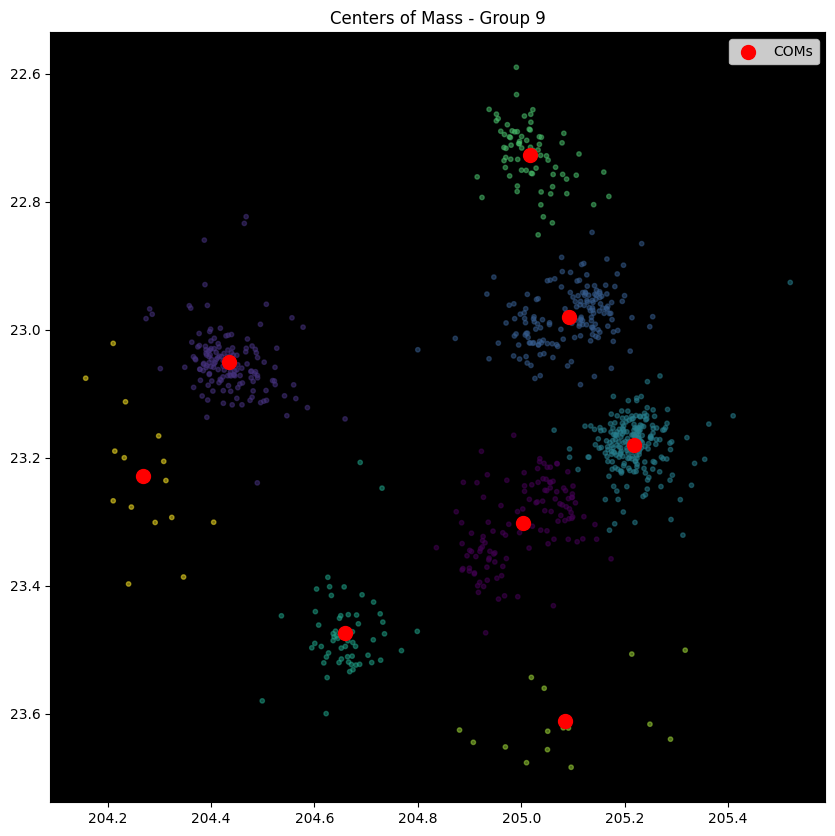

Minimum Bounding Rectangle:
 [[205.33786548  22.8308783 ]
 [204.48745745  22.55527166]
 [204.23425384  23.33655322]
 [205.08466187  23.61215986]]
Closest side of bounding rectangle:
 2
Closest line start: [204.23425384  23.33655322], end: [205.08466187  23.61215986]
Initial calculated angle: 0.3134063834332316 radians (17.956863043182974 degrees)
Adjusted angle by 180 degrees (for bottom side): 3.4549990370230246 radians (197.95686304318298 degrees)
Final rotation angle: -3.4549990370230246 radians (-197.95686304318298 degrees)
Rotation angle:
 -3.4549990370230246
Rotated Data:
 [[203.73212043  23.3861009 ]
 [203.7745554   23.34292065]
 [203.72323024  23.37539813]
 [203.67524295  23.34413311]
 [203.41168618  23.97650266]]
Rotated Centers of Mass (COM):
 [[203.51339188  23.60581725]
 [204.13106995  23.67007246]
 [203.52778193  23.94005664]
 [203.34761721  23.78888648]
 [203.78664815  23.33655322]
 [203.67733722  24.15784058]
 [203.34030035  23.33655322]
 [204.23425384  23.44967847]]
Fin

/tmp/ipykernel_9597/413643160.py:116: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


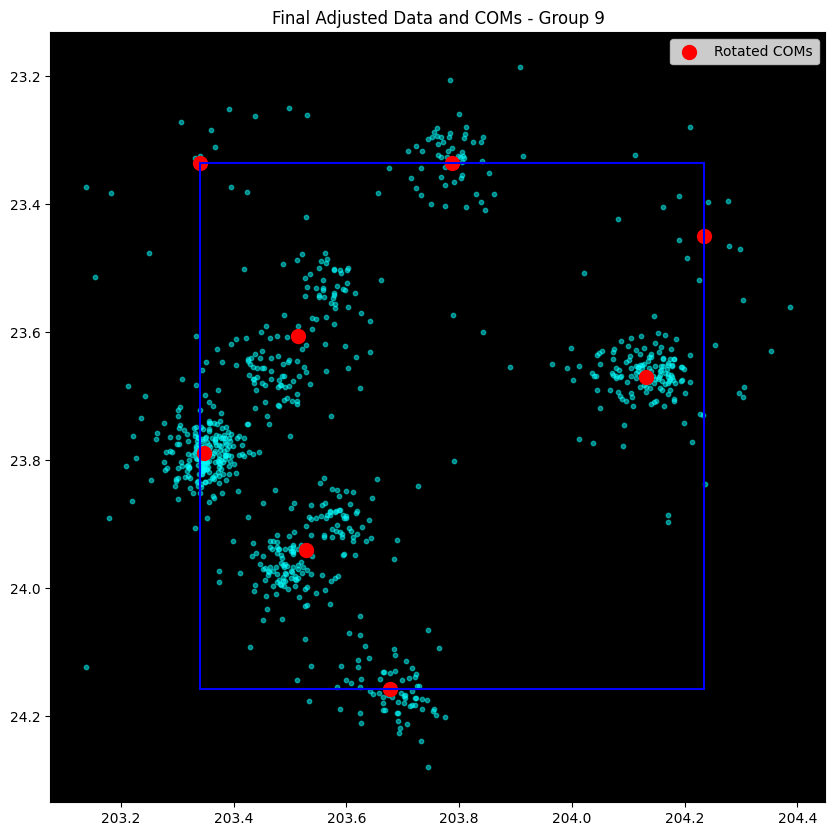

Second Highest COM:
 [203.51339188  23.60581725]
Right Most COM:
 [204.23425384  23.44967847]
Second Right Most COM:
 [204.13106995  23.67007246]
Robot COM:
 [203.51339188  23.60581725]


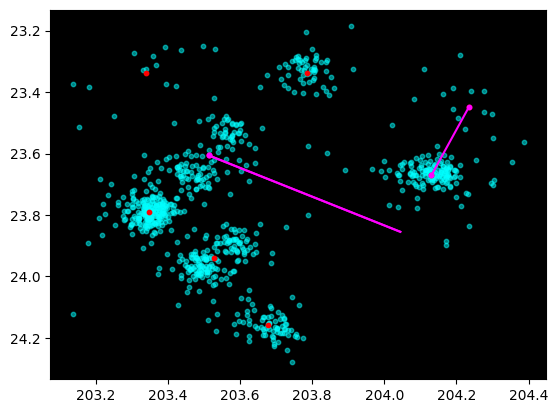

Ratio:
 1.0


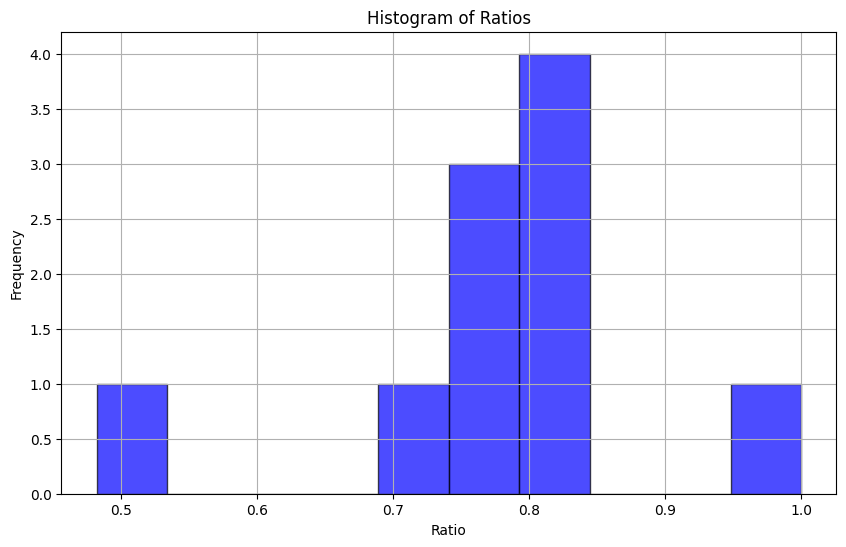

[np.float64(0.4822375367441374),
 np.float64(0.7977668958675053),
 np.float64(0.8079507924373667),
 np.float64(0.7771844927893748),
 np.float64(0.7921873542907827),
 np.float64(0.7189080236984043),
 np.float64(0.7799818899101107),
 np.float64(0.8210875630767464),
 np.float64(0.8431732755861153),
 np.float64(1.0)]

In [64]:
# Example usage
filename = 'data/n=10_origmi_locs.hdf5'
k = 8
process_multiple_origami_ratio(filename, k)